In [1]:
# Standard Library Imports
import os
import re
import json
import random
import multiprocessing
from typing import Any, Tuple

# Third-party Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from qiskit import QuantumCircuit, transpile
from qiskit_aer import QasmSimulator
from qiskit.visualization import plot_histogram
from IPython.display import display
from deap import creator, base, tools


import grape  # Grammatical evolution library
from grape import algorithms  # Evolutionary algorithms

In [2]:
# Get the number of logical CPU cores available
num_cores = os.cpu_count()
print("Number of CPU cores available:", num_cores)

Number of CPU cores available: 8


In [3]:
BNF_GRAMMAR = grape.Grammar("grammars/grover.bnf")

In [4]:
SEED = 2526
random.seed(SEED)
np.random.seed(SEED)

In [5]:
def generate_oracle_for_state(marked_state: str) -> str:
    """Generate Grover oracle code for a given marked state."""
    n = len(marked_state)
    code_lines = []
    # For each qubit where the marked state is '0', apply X gate.
    for i, bit in enumerate(marked_state):
        if bit == '0':
            code_lines.append(f"qc.x({i})")
    # Apply a multi-controlled phase flip (using Hadamard and mcx)
    code_lines.append(f"qc.h({n-1})")
    code_lines.append(f"qc.mcx(list(range({n-1})), {n-1})")
    code_lines.append(f"qc.h({n-1})")
    # Undo the X gates.
    for i, bit in enumerate(marked_state):
        if bit == '0':
            code_lines.append(f"qc.x({i})")
    return "\n".join(code_lines) + "\n"


In [6]:
class CircuitEvaluator:
    def __init__(self, shots: int = 512, log_dir: str = "logs_marked_state"):
        """
        Initialize the evaluator with simulation parameters and logging directory.
        """
        self.shots = shots
        self.log_dir = log_dir
        os.makedirs(self.log_dir, exist_ok=True)
    
    def decode_individual(self, ind) -> str:
        """
        Decodes an individual's genome into a phenotype code string.
        Returns:
            A string containing the code if decoding is successful,
            or None if invalid.
        """
        if ind.invalid or not hasattr(ind, 'phenotype'):
            return None
        try:
            phenotype_code = ind.phenotype
            if isinstance(phenotype_code, list):
                phenotype_code = "".join(phenotype_code)
            # Replace literal \n with actual newlines and clean quotes
            cleaned_code = re.sub(r'\\n', '\n', phenotype_code)
            cleaned_code = re.sub(r'^"|"$', '', cleaned_code)
            cleaned_code = re.sub(r'"\s+"', '\n', cleaned_code)
            return cleaned_code
        except Exception as ex:
            print(f"[Decode Error] {ex}")
            return None
    
    def execute_circuit(self, phenotype_code: str) -> QuantumCircuit:
        """
        Executes the phenotype code to produce a QuantumCircuit.
        Returns:
            The QuantumCircuit if 'qc' is found in the execution context,
            otherwise None.
        """
        local_vars = {}
        try:
            exec(phenotype_code, globals(), local_vars)
            if "qc" in local_vars:
                return local_vars["qc"]
            else:
                print("No circuit variable 'qc' found in phenotype code.")
                return None
        except Exception as e:
            print(f"Error executing phenotype code: {e}")
            return None
    
    def simulate_circuit(self, circuit: QuantumCircuit, marked_state: str) -> dict:
        """
        Simulates the circuit and returns performance metrics for the given marked state.
        
        Args:
            circuit (QuantumCircuit): The circuit to simulate.
            marked_state (str): The state to evaluate.
        
        Returns:
            dict: Contains counts, p_marked, error, gate_count, and depth.
        """
        simulator = QasmSimulator()
        compiled = transpile(circuit, simulator, optimization_level=0)
        result = simulator.run(compiled, shots=self.shots).result()
        counts = result.get_counts()
        # Reverse bitstrings to match the expected format.
        corrected = {k[::-1]: v for k, v in counts.items()}
        total = sum(corrected.values())
        p_marked = corrected.get(marked_state, 0) / total if total > 0 else 0.0
        error = 1 - p_marked
        return {
            "counts": corrected,
            "p_marked": p_marked,
            "error": error,
            "gate_count": compiled.size(),
            "depth": compiled.depth()
        }
    
    def log_evaluation(self, logs: list, generation: int, individual) -> None:
        """
        Logs the evaluation details for an individual to JSON and CSV files.
        """
        id_hash = hash(str(individual.genome)) % 10**8
        log_file_json = os.path.join(self.log_dir, f"eval_gen{generation}_id{id_hash}.json")
        log_file_csv = os.path.join(self.log_dir, f"eval_gen{generation}_id{id_hash}.csv")
        with open(log_file_json, "w") as f:
            json.dump(logs, f, indent=2)
        df = pd.DataFrame(logs)
        df[["state", "p_marked", "error", "gate_count", "depth"]].to_csv(log_file_csv, index=False)

In [7]:
def inject_oracle(phenotype_str: str, oracle_code: str) -> str:
    """Inject oracle code into the phenotype string."""
    pattern = r"(## Begin Oracle\n)(.*?)(## End Oracle\n)"
    new_block = r"\1" + oracle_code + r"\3"
    return re.sub(pattern, new_block, phenotype_str, flags=re.DOTALL)

In [8]:
def fitness_function_specialized_first_bit(
    phenotype_str,
    shots=512,
    threshold=0.48,         # A miss occurs if error (1 - p_marked) > 0.48
    target_first_bit="0",   # Evaluate only on states whose first bit is "0"
    gate_penalty_weight=0.02,  # Penalty weight applied to the average gate count
    log_states=True
):
    # Ensure we have a valid phenotype string.
    if not isinstance(phenotype_str, str):
        return (float('inf'), []) if log_states else float('inf')
    
    num_qubits = 3
    # Generate all 3-qubit states.
    all_states = [format(i, f"0{num_qubits}b") for i in range(2**num_qubits)]
    # Filter to only those states whose first bit equals the target.
    filtered_states = [state for state in all_states if state[0] == target_first_bit]
    
    evaluator = CircuitEvaluator(shots=shots)
    logs = []
    number_of_misses = 0
    max_error = 0.0
    
    for marked_state in filtered_states:
        # Generate the oracle for this marked state.
        oracle_code = generate_oracle_for_state(marked_state)
        # Inject the oracle into the candidate phenotype.
        modified_code = inject_oracle(phenotype_str, oracle_code)
        qc = evaluator.execute_circuit(modified_code)
        if qc is None:
            continue
        # Simulate the circuit for the marked state.
        result = evaluator.simulate_circuit(qc, marked_state)
        p_marked = result["p_marked"]
        error = 1 - p_marked
        
        if error > threshold:
            number_of_misses += 1
        max_error = max(max_error, error)
        
        if log_states:
            logs.append({
                "state": marked_state,
                "p_marked": p_marked,
                "error": error,
                "oracle": oracle_code,
                "code": modified_code,
                "counts": result["counts"],
                "gate_count": result.get("gate_count", None),
                "depth": result.get("depth", None)
            })
    
    # Calculate average gate count from logs (if available)
    if logs:
        gate_counts = [log["gate_count"] for log in logs if log.get("gate_count") is not None]
        avg_gate = np.mean(gate_counts) if gate_counts else 0
    else:
        avg_gate = 0

    # Lexicographic fitness: number_of_misses is heavily penalized (10x) over maximum error,
    # and we add a penalty for larger circuits.
    fitness_score = 10 * number_of_misses + max_error + gate_penalty_weight * avg_gate
    
    if log_states:
        return (fitness_score, logs)
    else:
        return fitness_score

In [9]:
def plot_single_state_histogram(log):
    """
    Plot a histogram of measurement counts for a single marked state.
    """
    counts = log.get("counts", {})
    if not counts or sum(counts.values()) == 0:
        print("No valid counts to plot.")
        return
    plt.figure(figsize=(6, 4))
    plot_histogram(counts, title=f"Counts for Marked State {log['state']}")
    plt.show()

In [10]:
POPULATION_SIZE    = 1000
MAX_GENERATIONS    = 100
N_GEN = 1
P_CROSSOVER        = 0.7     
P_MUTATION         = 0.01
ELITE_SIZE         = 1
HALLOFFAME_SIZE    = 1
CODON_SIZE         = 400
MAX_TREE_DEPTH     = 50      
TOURNAMENT_SIZE    = 5
MIN_INIT_DEPTH     = 20        
MAX_INIT_DEPTH     = 40       
CODON_CONSUMPTION  = "lazy"   
GENOME_REPRESENTATION = 'list'
REPORT_ITEMS = ['gen', 'invalid', 'avg', 'std', 'min', 'max',
                'fitness_test',
                'best_ind_length', 'avg_length',
                'best_ind_nodes', 'avg_nodes',
                'avg_depth',
                'avg_used_codons', 'best_ind_used_codons',
                'selection_time', 'generation_time']

In [11]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", grape.Individual, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register(
    "populationCreator",
    grape.sensible_initialisation,
    creator.Individual,
    bnf_grammar=BNF_GRAMMAR,
    min_init_depth=MIN_INIT_DEPTH,  
    max_init_depth=MAX_INIT_DEPTH,  
    codon_size=CODON_SIZE,
    codon_consumption=CODON_CONSUMPTION,
    genome_representation=GENOME_REPRESENTATION,
)
toolbox.register("mate", grape.crossover_onepoint)
toolbox.register("mutate", grape.mutation_int_flip_per_codon)
toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE)

pool = multiprocessing.Pool(8)
toolbox.register("map", pool.map)

In [12]:
LOG_DIR = "logs_marked_state"
os.makedirs(LOG_DIR, exist_ok=True)

In [13]:
def evaluate_with_logging(individual, pts_train=None):
    evaluator = CircuitEvaluator(shots=512, log_dir=LOG_DIR)
    phenotype_str = evaluator.decode_individual(individual)
    if not phenotype_str:
        return (float('inf'),)
    # Evaluate with logs enabled.
    fitness_val, logs = fitness_function_specialized_first_bit(
        phenotype_str, 
        shots=512, 
        threshold=0.48, 
        target_first_bit="0", 
        log_states=True
    )
    # Log the evaluation (for example, print a message to confirm logging).
    gen = getattr(individual, "generation", "unknown")
    # print(f"Logging evaluation for generation {gen} for individual with genome {individual.genome}")
    evaluator.log_evaluation(logs, gen, individual)
    return (fitness_val,)

toolbox.register("evaluate", evaluate_with_logging)

gen = 0 , Best fitness = (np.float64(31.129296875),)
gen = 1 , Best fitness = (np.float64(31.129296875),) , Number of invalids = 133

[Generation 0] Best Fitness: 31.1293


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


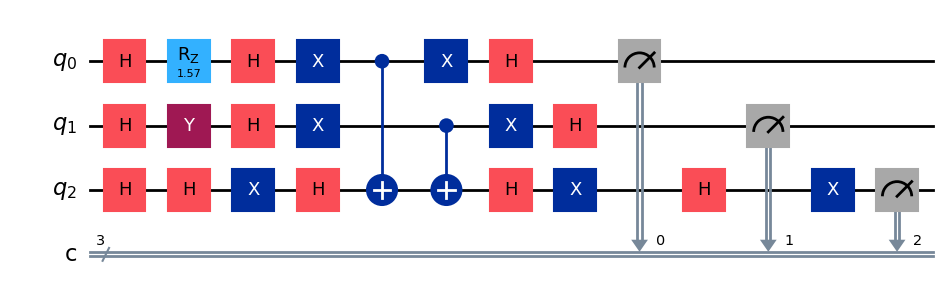

gen = 0 , Best fitness = (np.float64(31.129296875),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(31.10390625),) , Number of invalids = 70

[Generation 1] Best Fitness: 31.1039


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


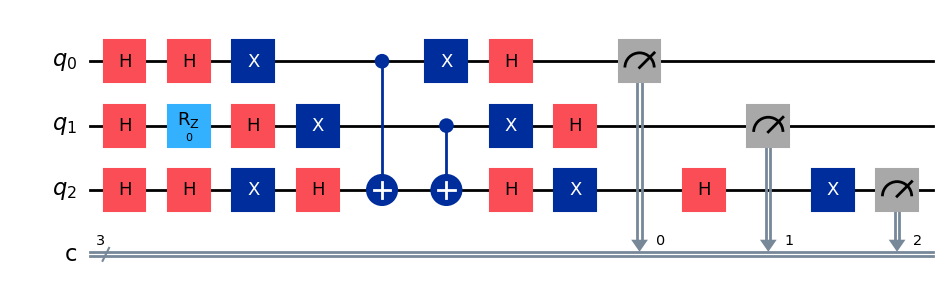

gen = 0 , Best fitness = (np.float64(31.10390625),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(31.10390625),) , Number of invalids = 79

[Generation 2] Best Fitness: 31.1039


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


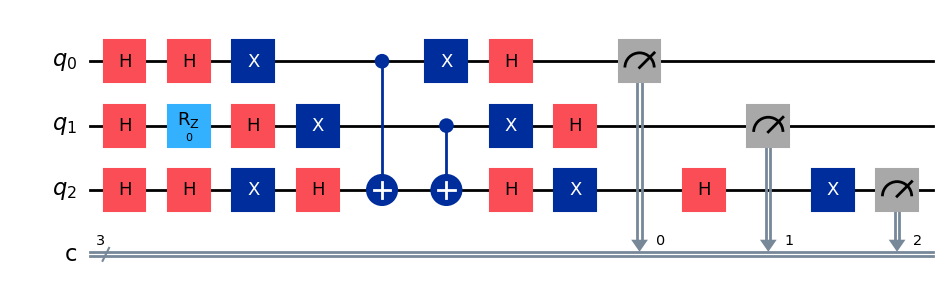

gen = 0 , Best fitness = (np.float64(31.10390625),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(21.133203125),) , Number of invalids = 62

[Generation 3] Best Fitness: 21.1332


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


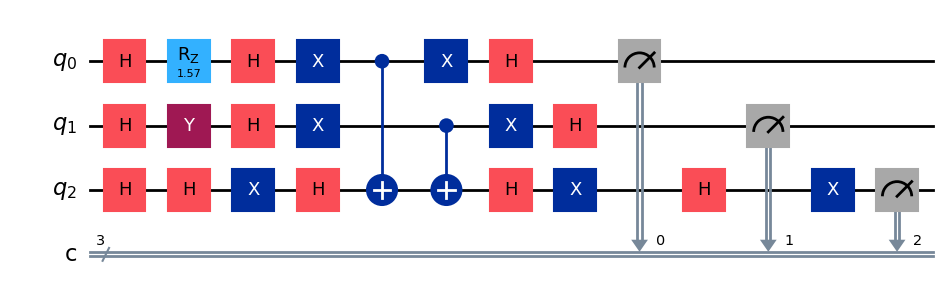

gen = 0 , Best fitness = (np.float64(21.133203125),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(11.230234375),) , Number of invalids = 83

[Generation 4] Best Fitness: 11.2302


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


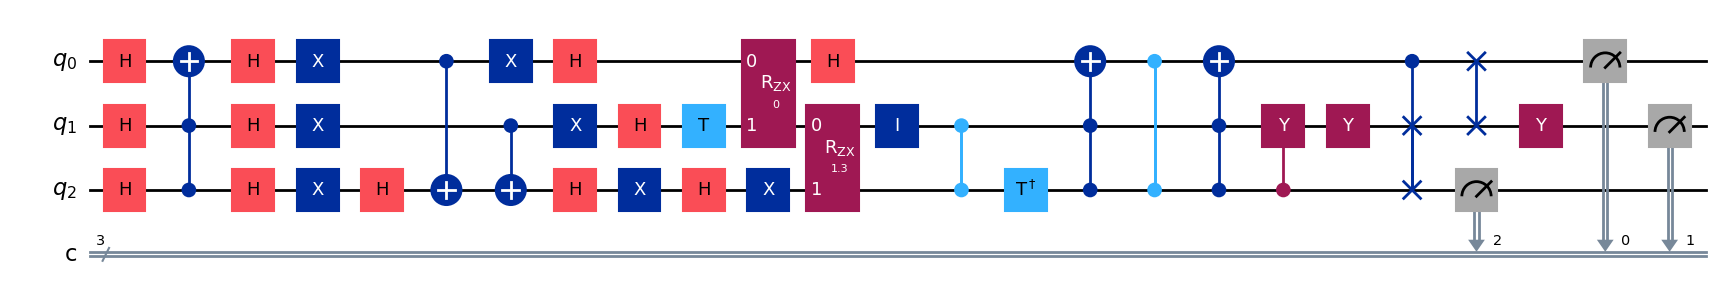

gen = 0 , Best fitness = (np.float64(11.230234375),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(11.129296875),) , Number of invalids = 72

[Generation 5] Best Fitness: 11.1293


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


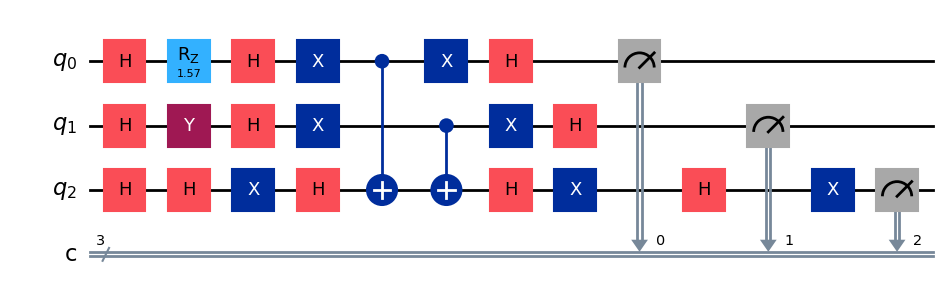

gen = 0 , Best fitness = (np.float64(11.129296875),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(11.129296875),) , Number of invalids = 83

[Generation 6] Best Fitness: 11.1293


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


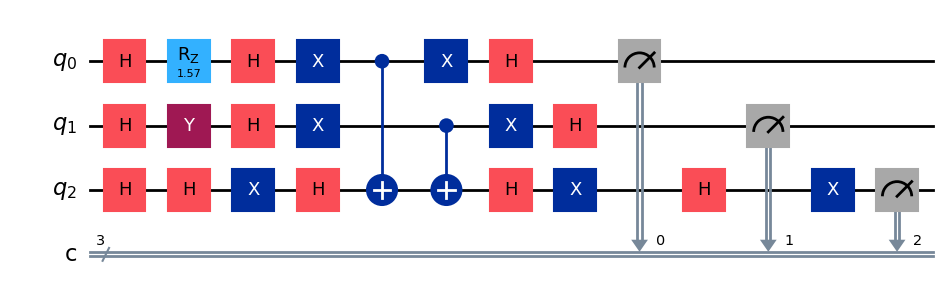

gen = 0 , Best fitness = (np.float64(11.129296875),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(1.218515625),) , Number of invalids = 78

[Generation 7] Best Fitness: 1.2185


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


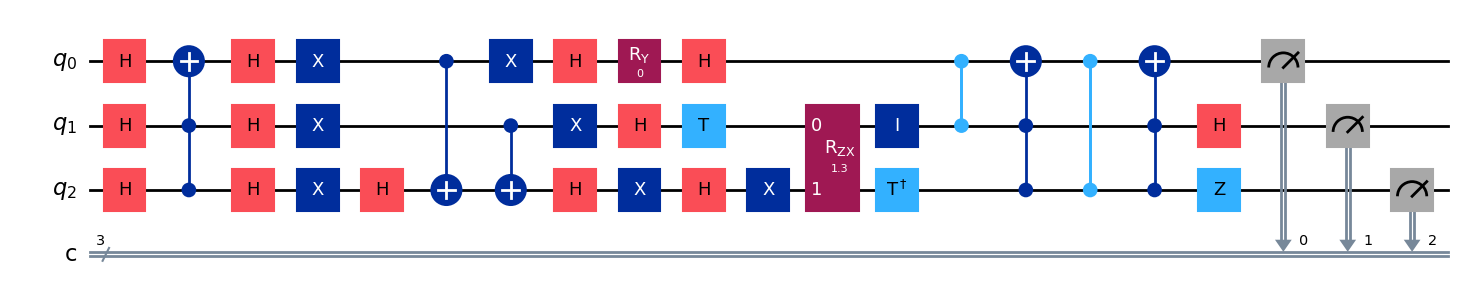

gen = 0 , Best fitness = (np.float64(1.218515625),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(1.21265625),) , Number of invalids = 67

[Generation 8] Best Fitness: 1.2127


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


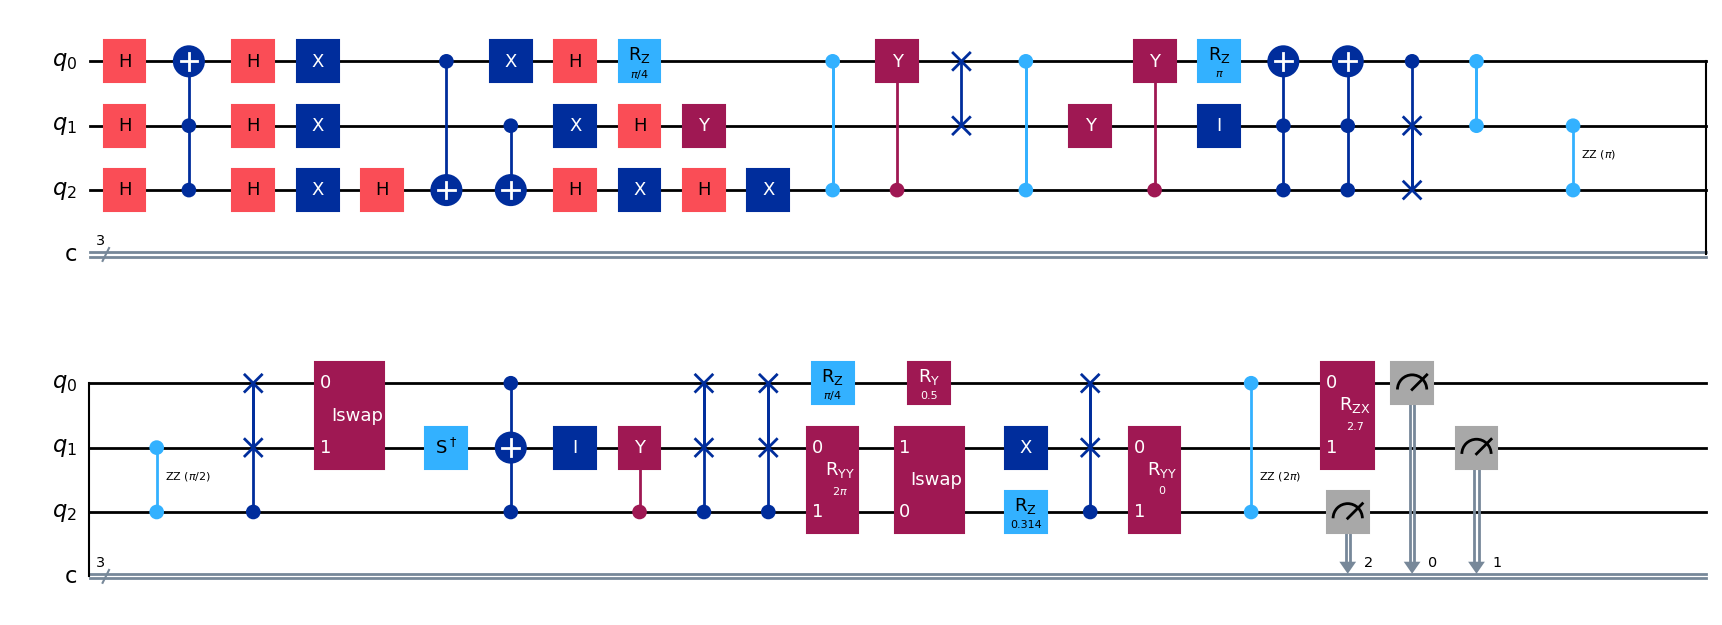

gen = 0 , Best fitness = (np.float64(1.21265625),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(1.21265625),) , Number of invalids = 41

[Generation 9] Best Fitness: 1.2127


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


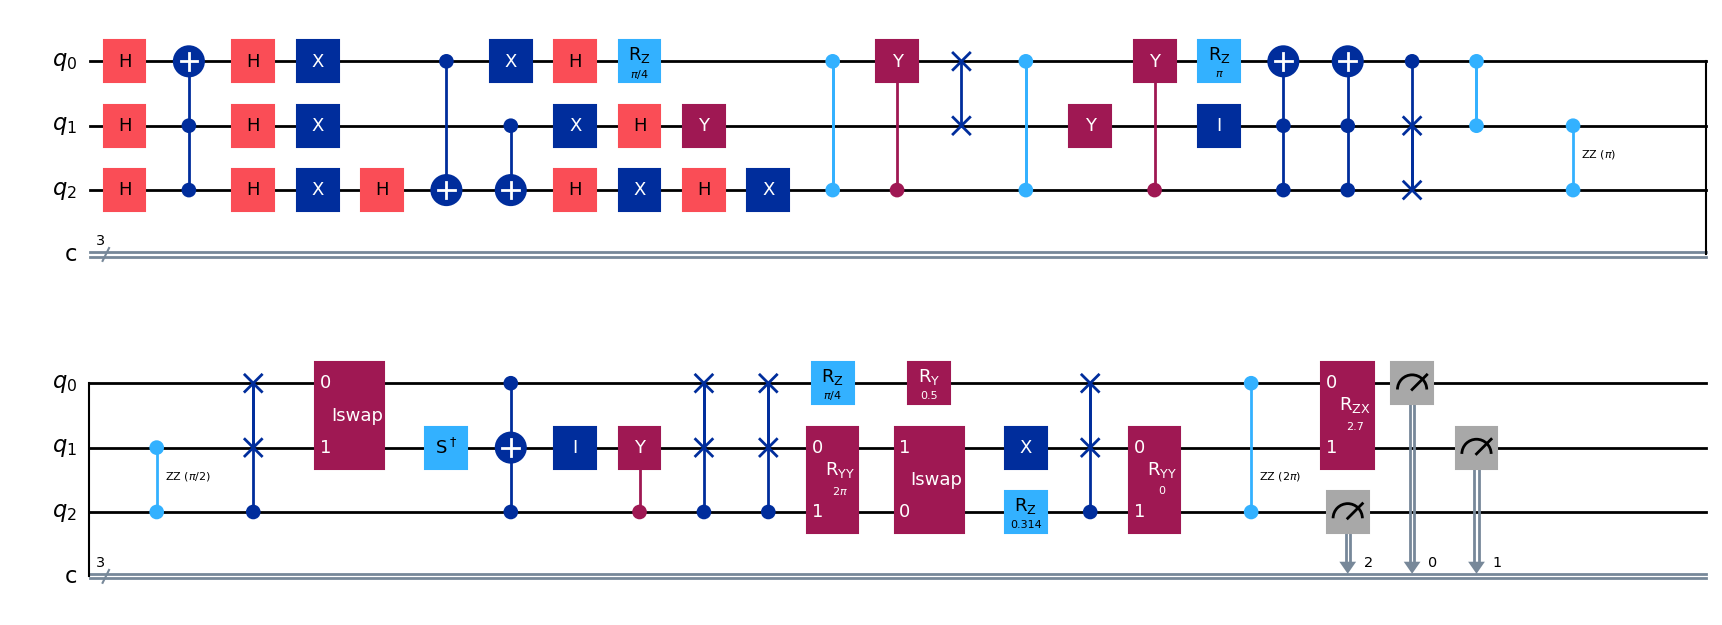

gen = 0 , Best fitness = (np.float64(1.21265625),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(1.203359375),) , Number of invalids = 56

[Generation 10] Best Fitness: 1.2034


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


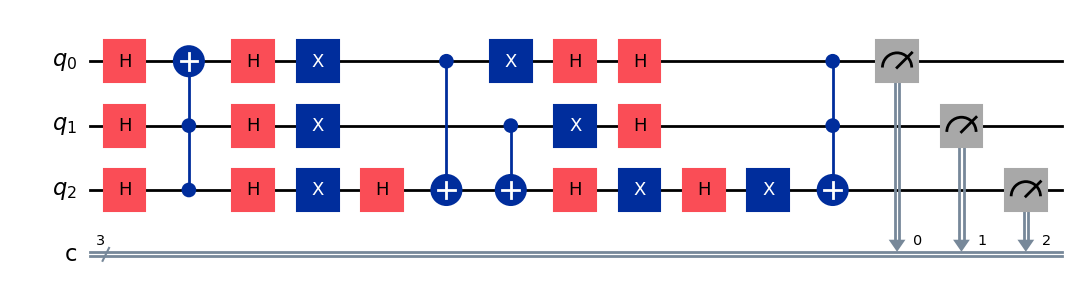

gen = 0 , Best fitness = (np.float64(1.203359375),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(1.203359375),) , Number of invalids = 56

[Generation 11] Best Fitness: 1.2034


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


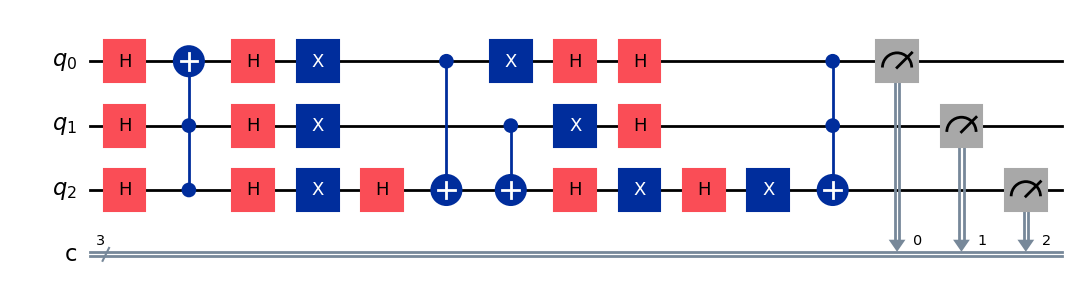

gen = 0 , Best fitness = (np.float64(1.203359375),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(1.20140625),) , Number of invalids = 49

[Generation 12] Best Fitness: 1.2014


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


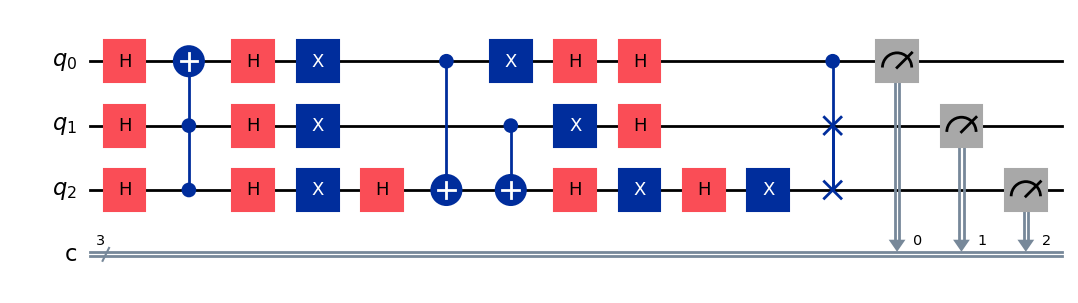

gen = 0 , Best fitness = (np.float64(1.20140625),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(1.070703125),) , Number of invalids = 45

[Generation 13] Best Fitness: 1.0707


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


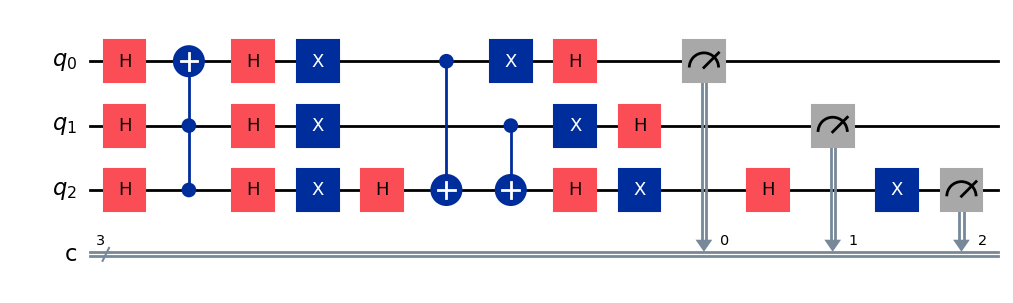

gen = 0 , Best fitness = (np.float64(1.070703125),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(1.070703125),) , Number of invalids = 44

[Generation 14] Best Fitness: 1.0707


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


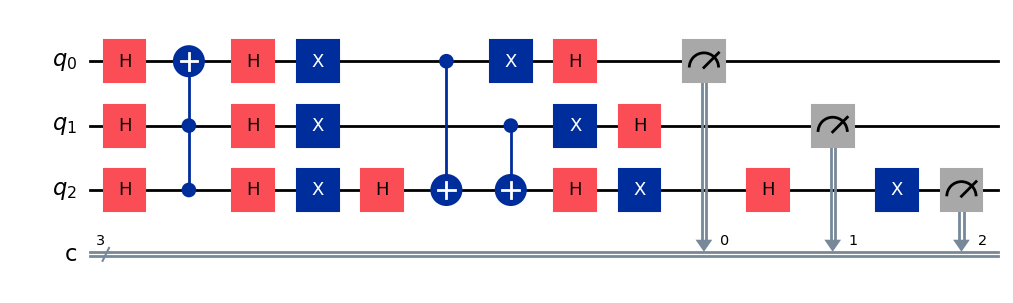

gen = 0 , Best fitness = (np.float64(1.070703125),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(1.070703125),) , Number of invalids = 30

[Generation 15] Best Fitness: 1.0707


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


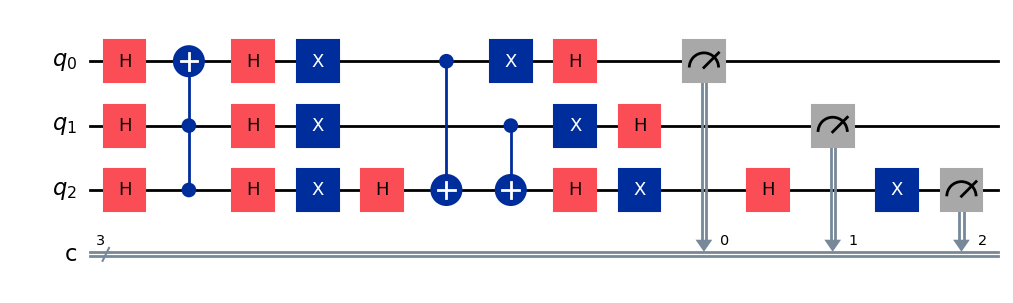

gen = 0 , Best fitness = (np.float64(1.070703125),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(1.070703125),) , Number of invalids = 17

[Generation 16] Best Fitness: 1.0707


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


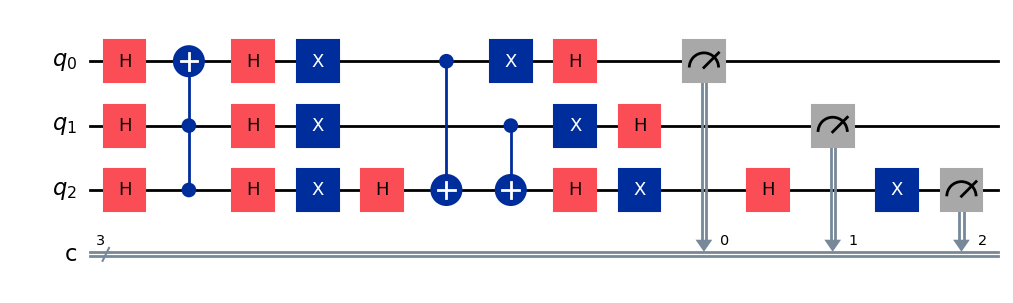

gen = 0 , Best fitness = (np.float64(1.070703125),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(1.0575),) , Number of invalids = 12

[Generation 17] Best Fitness: 1.0575


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


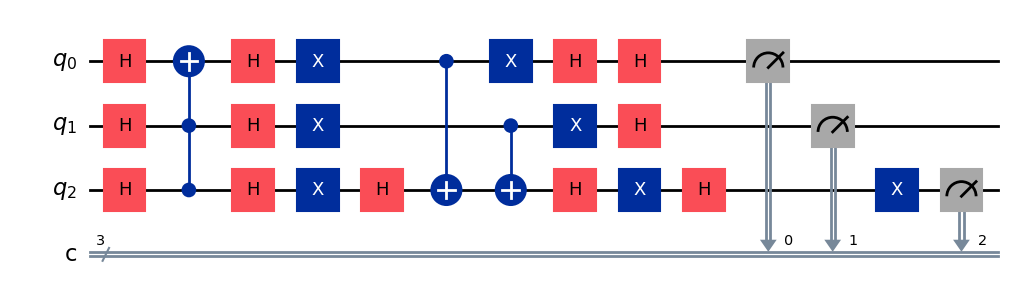

gen = 0 , Best fitness = (np.float64(1.0575),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(1.05359375),) , Number of invalids = 6

[Generation 18] Best Fitness: 1.0536


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


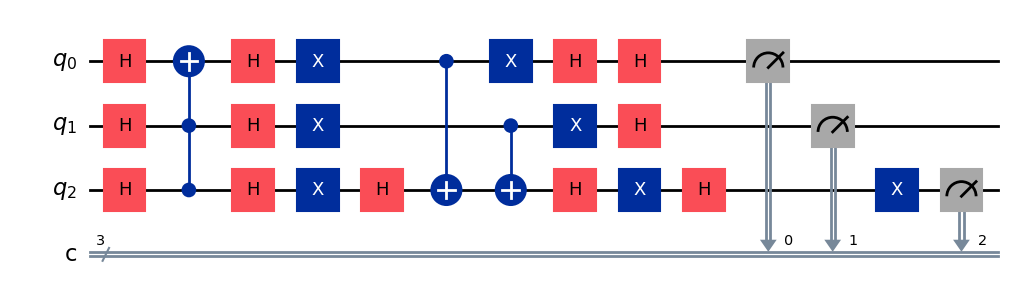

gen = 0 , Best fitness = (np.float64(1.05359375),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(1.05359375),) , Number of invalids = 1

[Generation 19] Best Fitness: 1.0536


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


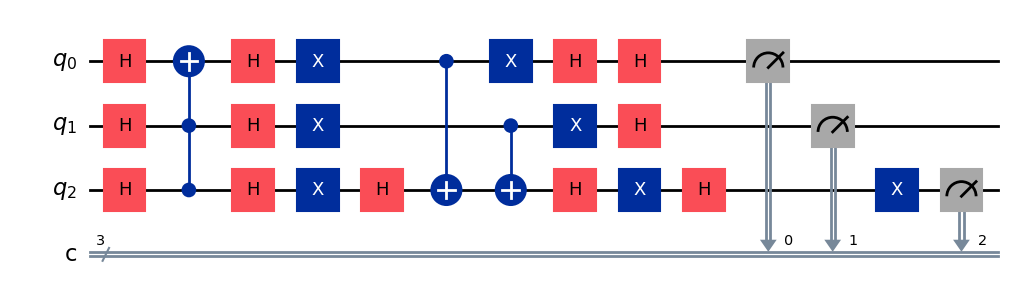

gen = 0 , Best fitness = (np.float64(1.05359375),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(1.05359375),) , Number of invalids = 2

[Generation 20] Best Fitness: 1.0536


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


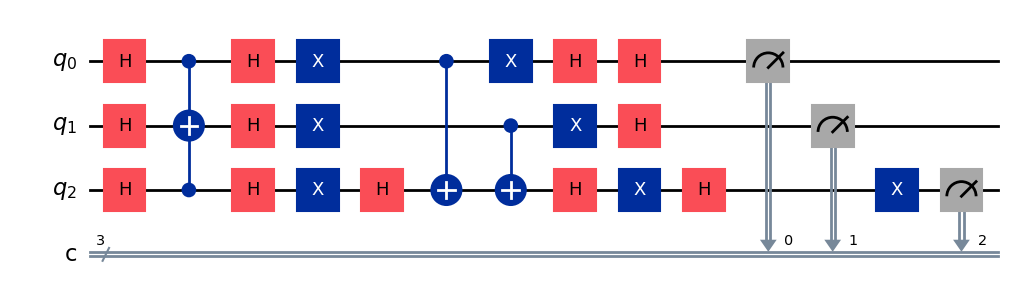

gen = 0 , Best fitness = (np.float64(1.05359375),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(1.05359375),) , Number of invalids = 3

[Generation 21] Best Fitness: 1.0536


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


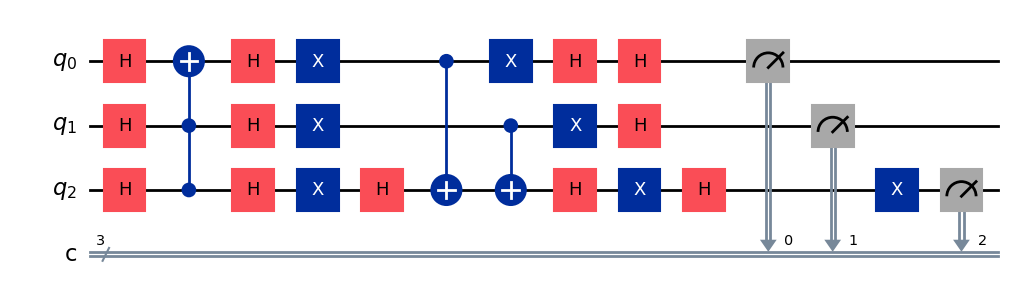

gen = 0 , Best fitness = (np.float64(1.05359375),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(1.047734375),) , Number of invalids = 0

[Generation 22] Best Fitness: 1.0477


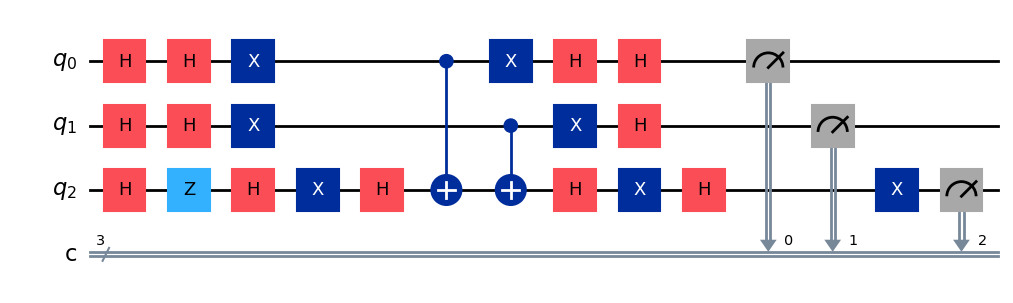

gen = 0 , Best fitness = (np.float64(1.047734375),)
gen = 1 , Best fitness = (np.float64(1.04578125),) , Number of invalids = 0

[Generation 23] Best Fitness: 1.0458


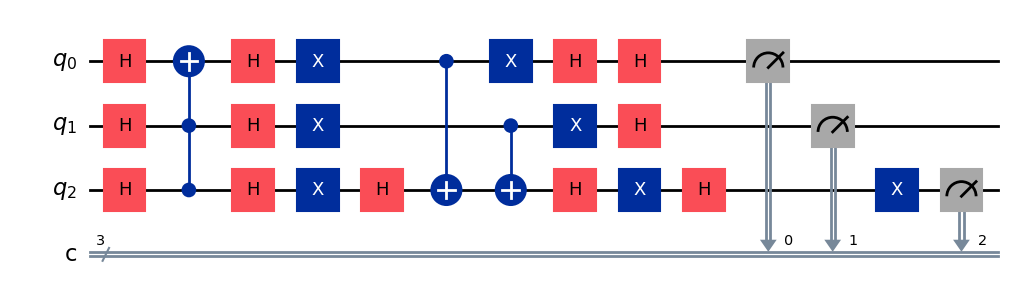

gen = 0 , Best fitness = (np.float64(1.04578125),)
gen = 1 , Best fitness = (np.float64(1.04578125),) , Number of invalids = 3

[Generation 24] Best Fitness: 1.0458


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


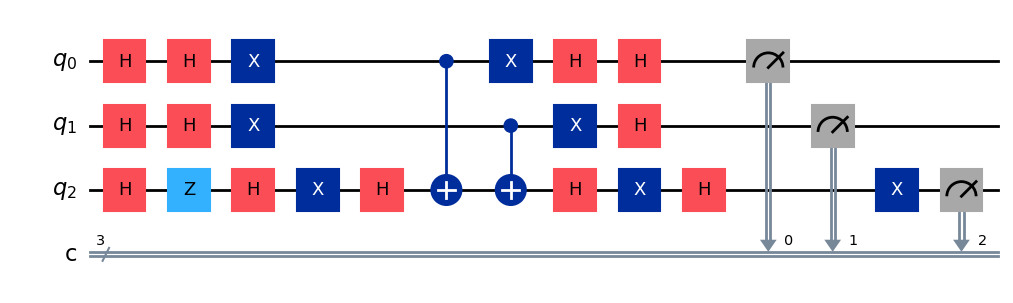

gen = 0 , Best fitness = (np.float64(1.04578125),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(1.04578125),) , Number of invalids = 2

[Generation 25] Best Fitness: 1.0458


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


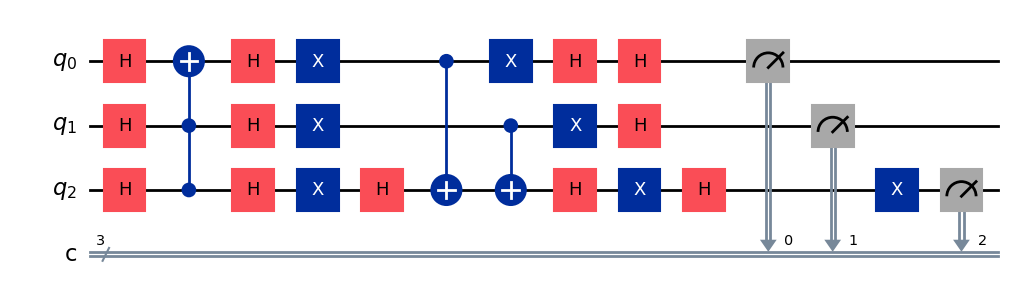

gen = 0 , Best fitness = (np.float64(1.04578125),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(1.039921875),) , Number of invalids = 4

[Generation 26] Best Fitness: 1.0399


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


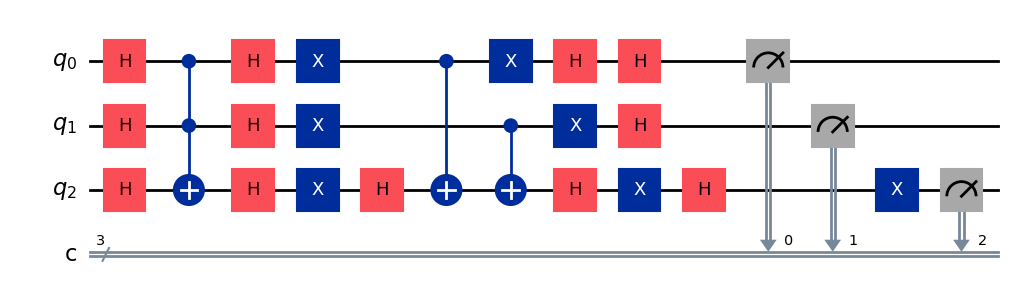

gen = 0 , Best fitness = (np.float64(1.039921875),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(1.039921875),) , Number of invalids = 0

[Generation 27] Best Fitness: 1.0399


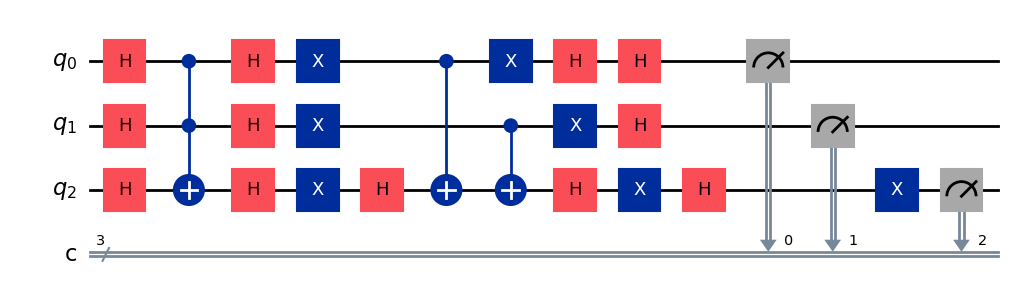

gen = 0 , Best fitness = (np.float64(1.039921875),)
gen = 1 , Best fitness = (np.float64(1.039921875),) , Number of invalids = 2

[Generation 28] Best Fitness: 1.0399


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


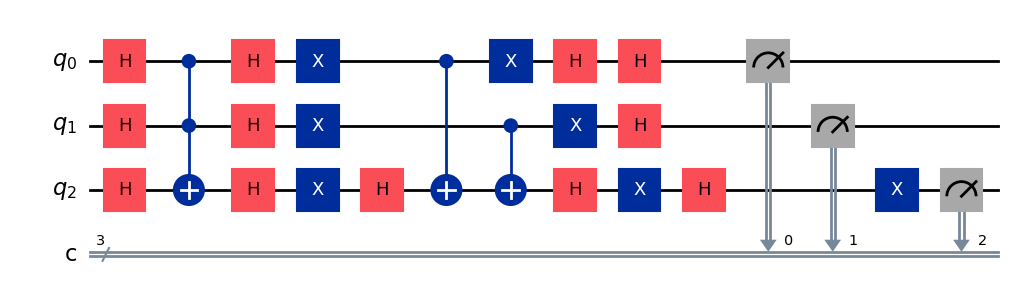

gen = 0 , Best fitness = (np.float64(1.039921875),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(1.039921875),) , Number of invalids = 5

[Generation 29] Best Fitness: 1.0399


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


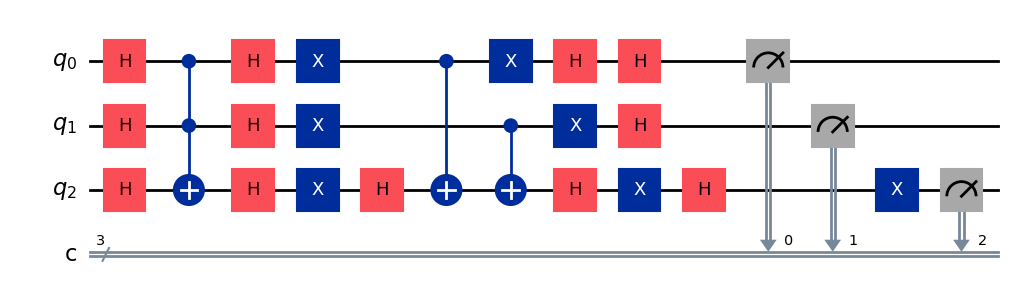

gen = 0 , Best fitness = (np.float64(1.039921875),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(1.039921875),) , Number of invalids = 1

[Generation 30] Best Fitness: 1.0399


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


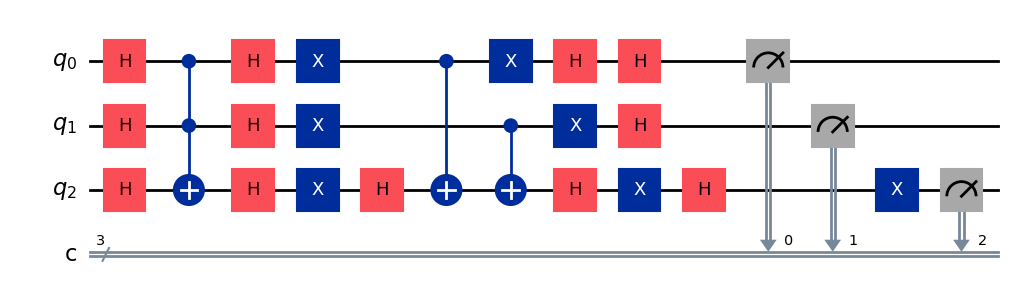

gen = 0 , Best fitness = (np.float64(1.039921875),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(1.039921875),) , Number of invalids = 0

[Generation 31] Best Fitness: 1.0399


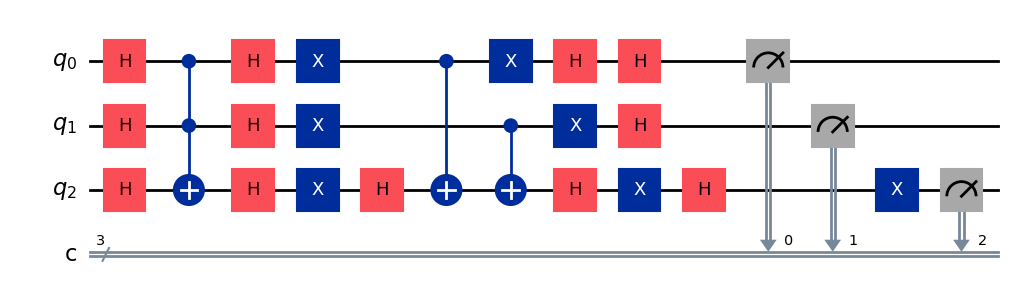

gen = 0 , Best fitness = (np.float64(1.039921875),)
gen = 1 , Best fitness = (np.float64(1.039921875),) , Number of invalids = 0

[Generation 32] Best Fitness: 1.0399


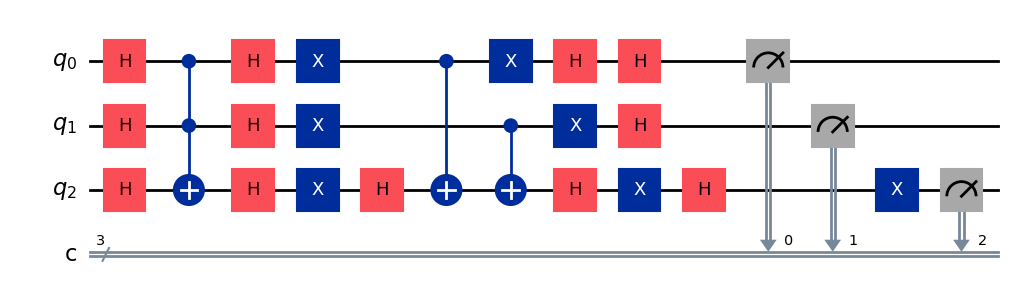

gen = 0 , Best fitness = (np.float64(1.039921875),)
gen = 1 , Best fitness = (np.float64(1.039921875),) , Number of invalids = 0

[Generation 33] Best Fitness: 1.0399


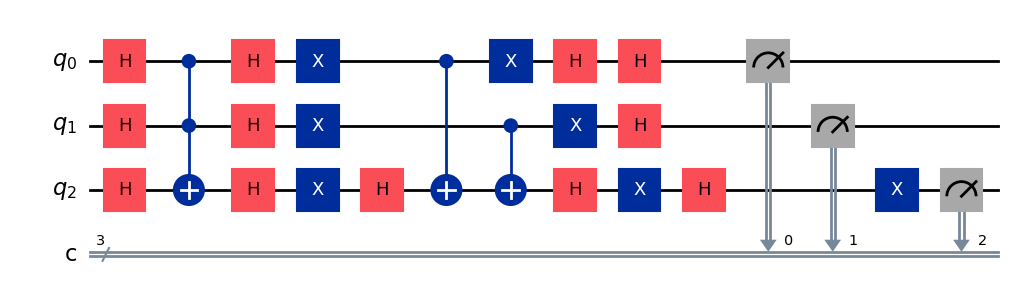

gen = 0 , Best fitness = (np.float64(1.039921875),)
gen = 1 , Best fitness = (np.float64(1.039921875),) , Number of invalids = 1

[Generation 34] Best Fitness: 1.0399


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


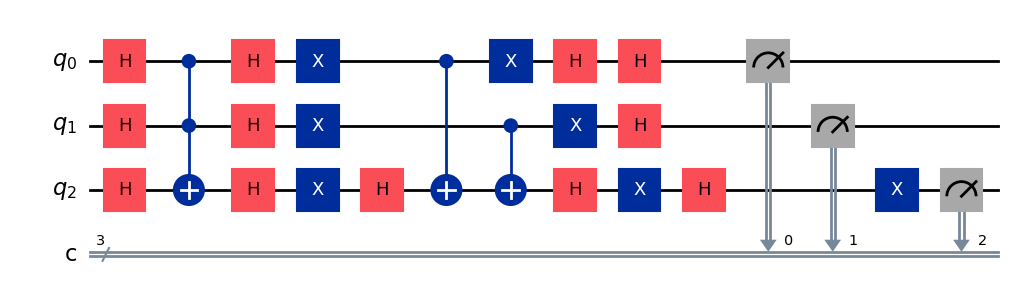

gen = 0 , Best fitness = (np.float64(1.039921875),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(1.039921875),) , Number of invalids = 0

[Generation 35] Best Fitness: 1.0399


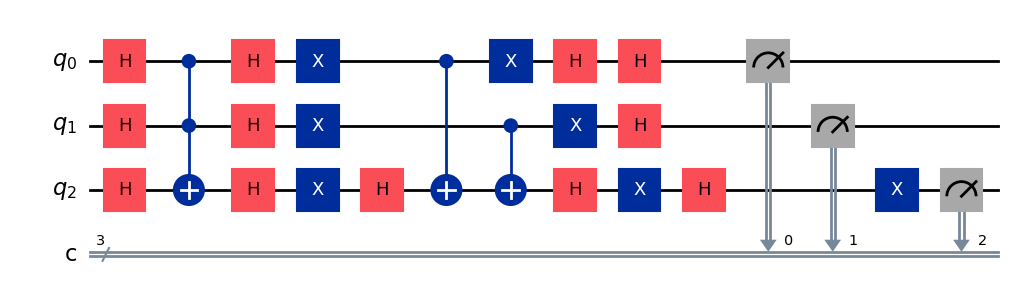

gen = 0 , Best fitness = (np.float64(1.039921875),)
gen = 1 , Best fitness = (np.float64(1.039921875),) , Number of invalids = 0

[Generation 36] Best Fitness: 1.0399


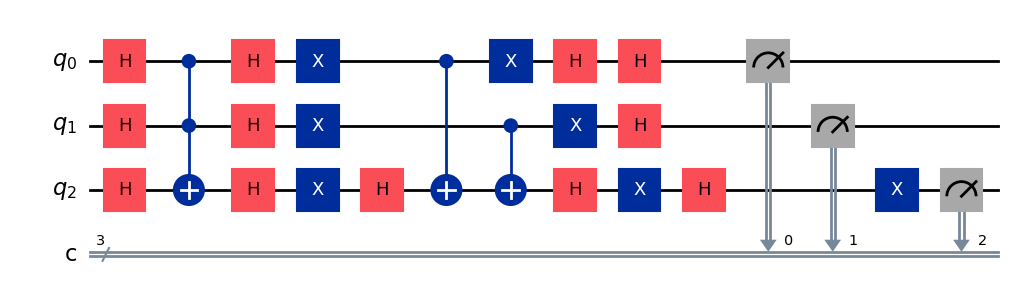

gen = 0 , Best fitness = (np.float64(1.039921875),)
gen = 1 , Best fitness = (np.float64(1.039921875),) , Number of invalids = 0

[Generation 37] Best Fitness: 1.0399


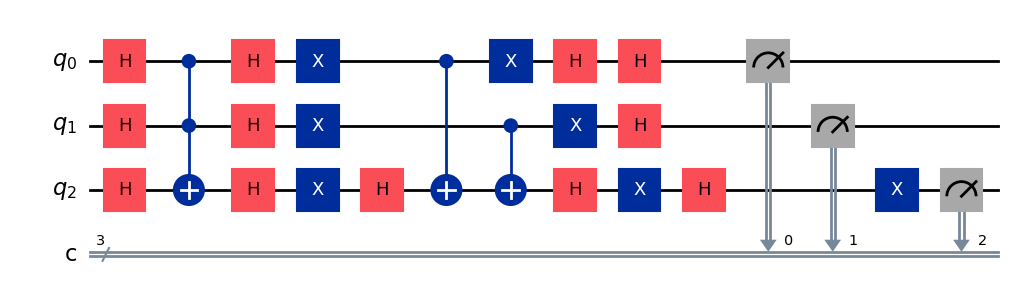

gen = 0 , Best fitness = (np.float64(1.039921875),)
gen = 1 , Best fitness = (np.float64(1.039921875),) , Number of invalids = 0

[Generation 38] Best Fitness: 1.0399


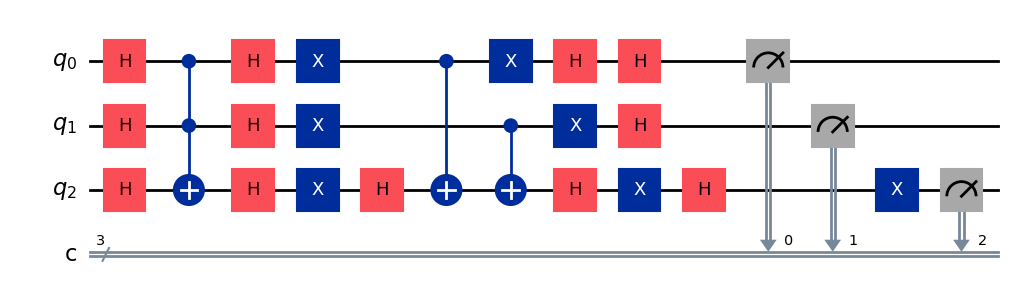

gen = 0 , Best fitness = (np.float64(1.039921875),)
gen = 1 , Best fitness = (np.float64(1.036015625),) , Number of invalids = 0

[Generation 39] Best Fitness: 1.0360


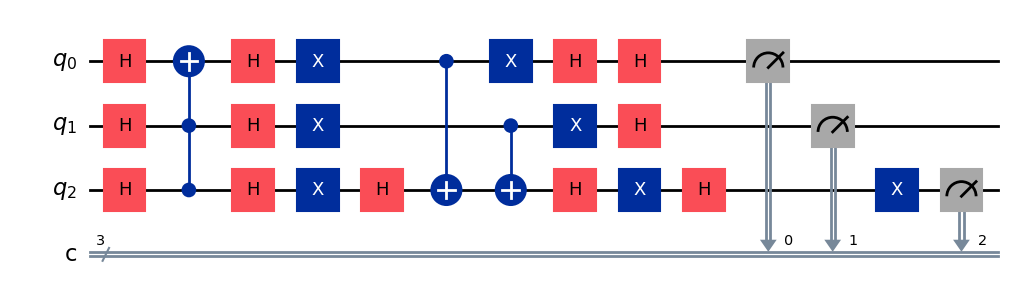

gen = 0 , Best fitness = (np.float64(1.036015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 40] Best Fitness: 1.0302


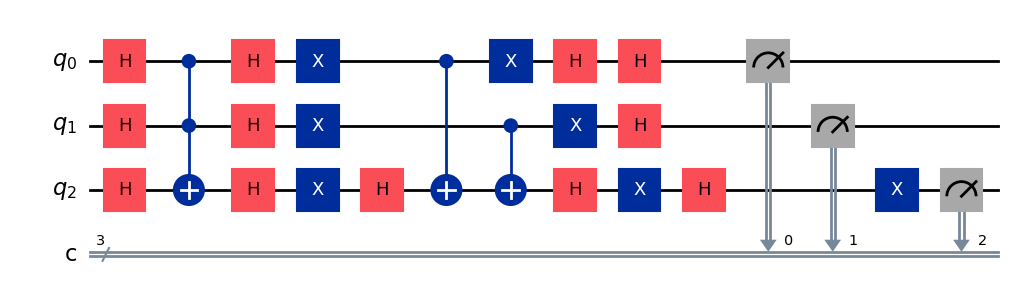

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 41] Best Fitness: 1.0302


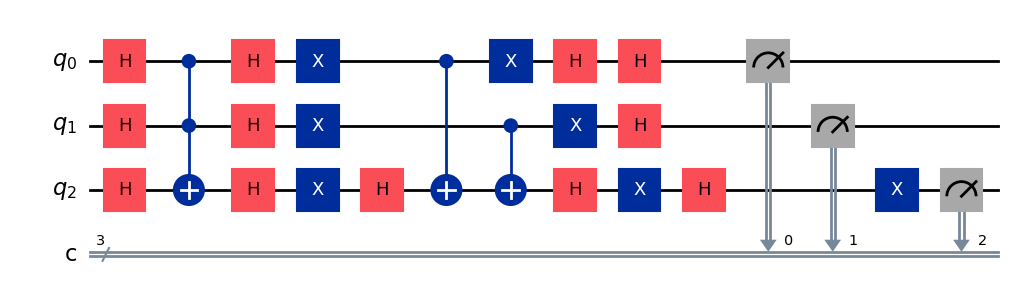

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 42] Best Fitness: 1.0302


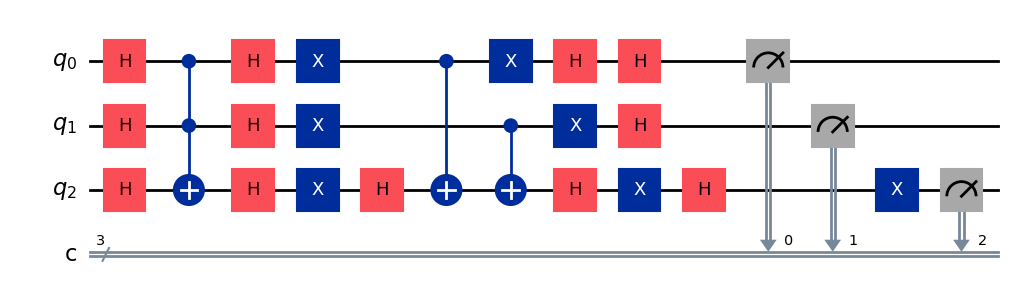

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 43] Best Fitness: 1.0302


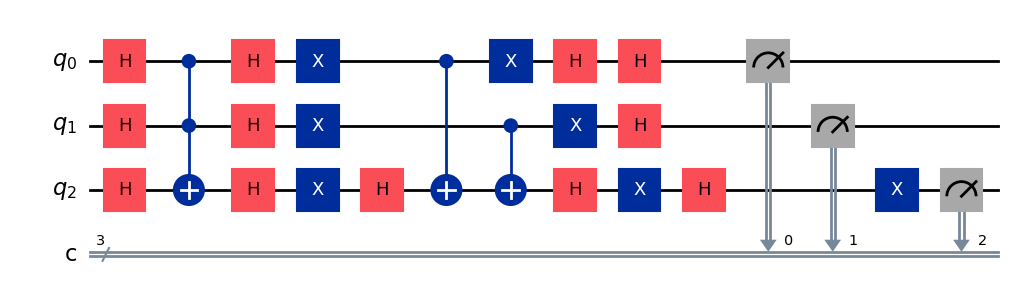

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 44] Best Fitness: 1.0302


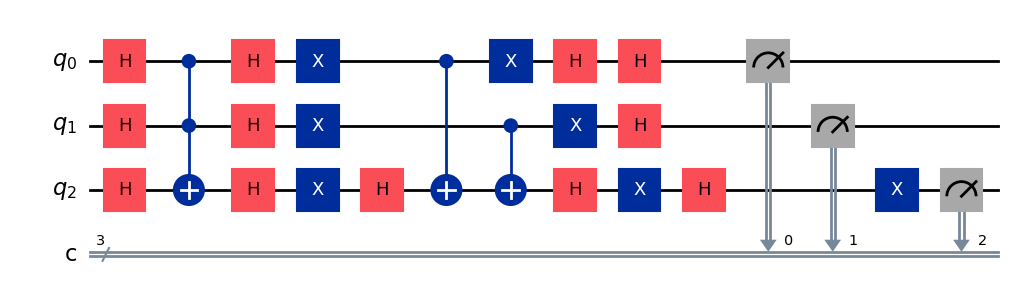

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 1

[Generation 45] Best Fitness: 1.0302


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


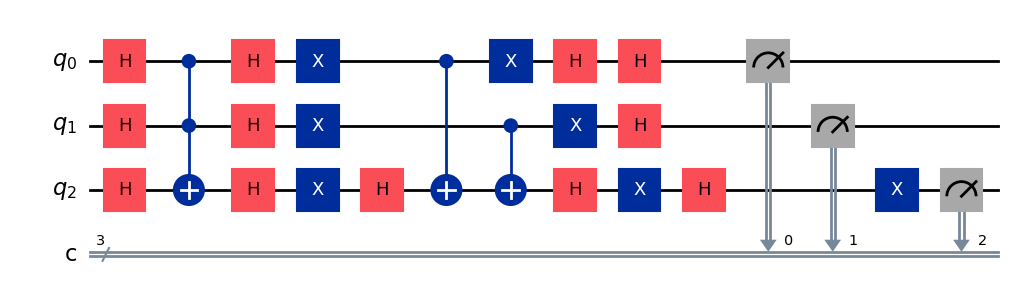

gen = 0 , Best fitness = (np.float64(1.03015625),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 46] Best Fitness: 1.0302


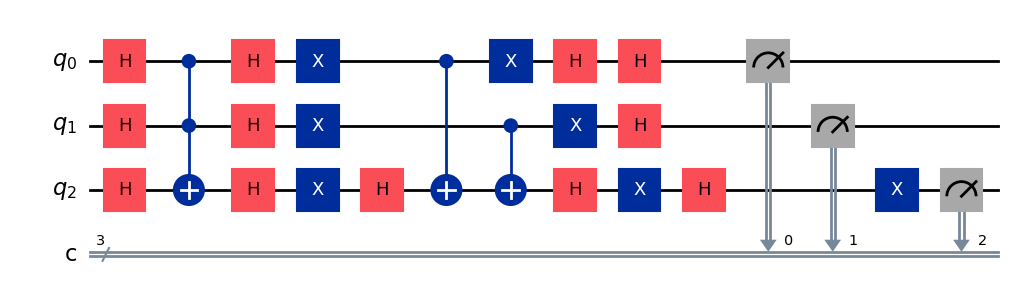

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 47] Best Fitness: 1.0302


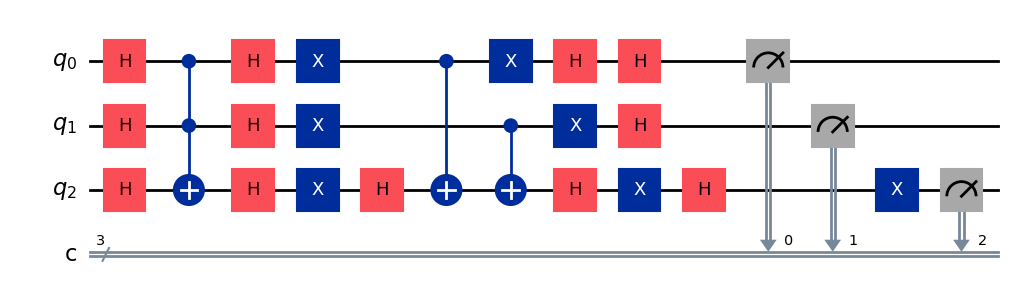

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 48] Best Fitness: 1.0302


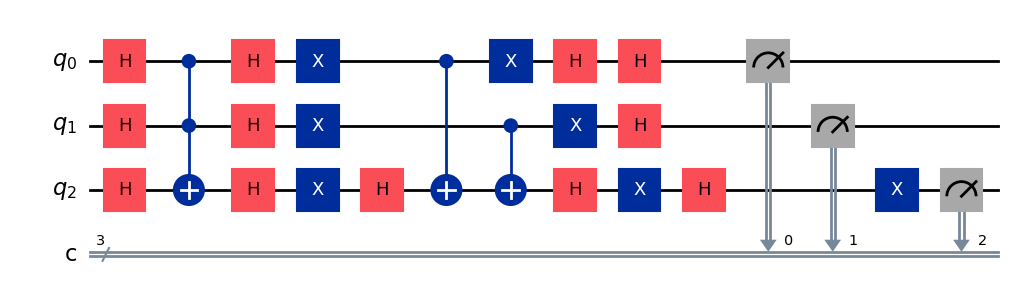

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 2

[Generation 49] Best Fitness: 1.0302


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


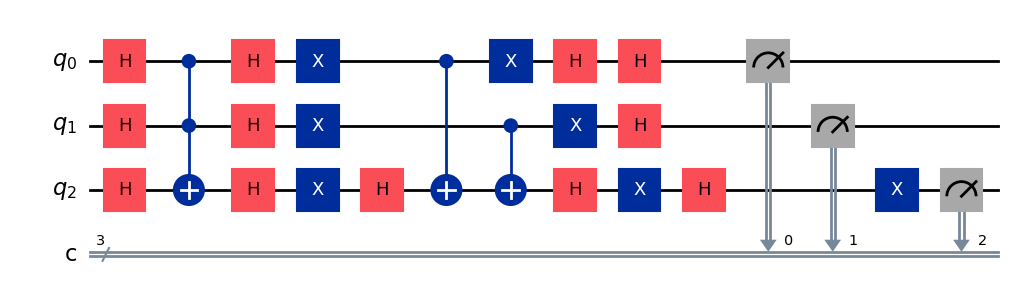

gen = 0 , Best fitness = (np.float64(1.03015625),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 50] Best Fitness: 1.0302


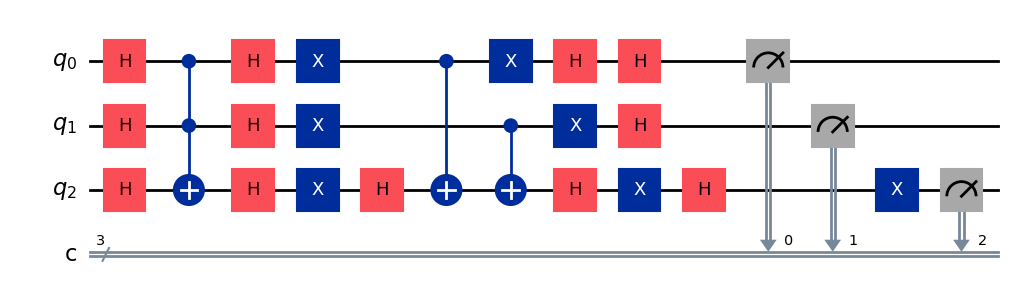

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 51] Best Fitness: 1.0302


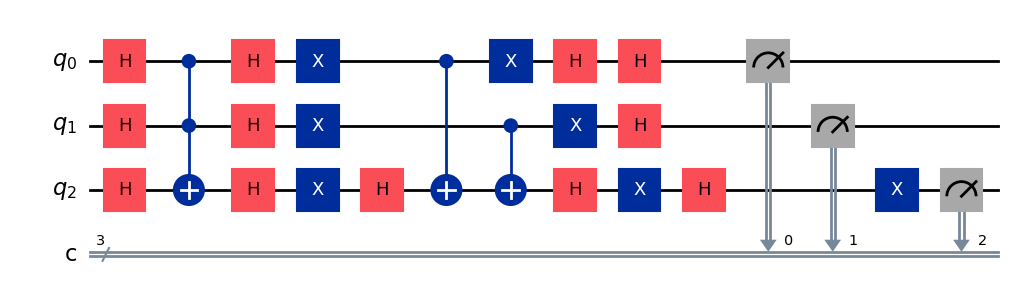

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 52] Best Fitness: 1.0302


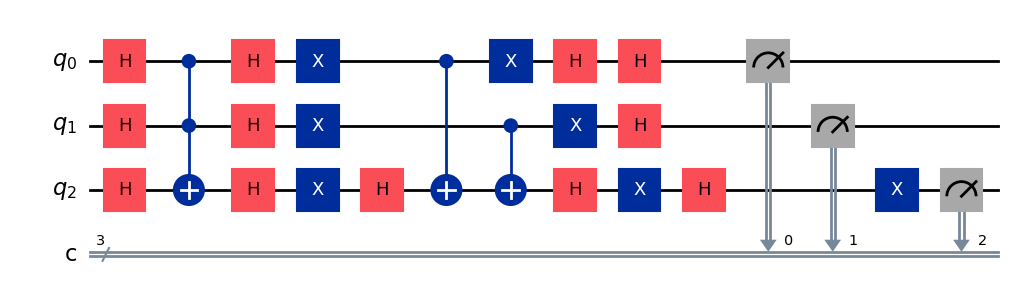

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 1

[Generation 53] Best Fitness: 1.0302


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


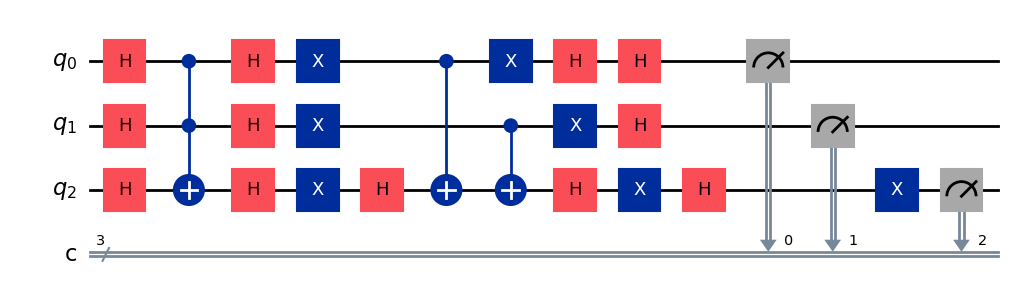

gen = 0 , Best fitness = (np.float64(1.03015625),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 54] Best Fitness: 1.0302


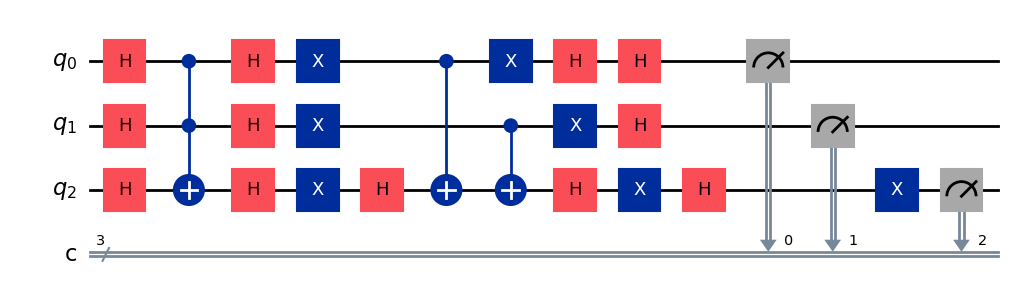

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 55] Best Fitness: 1.0302


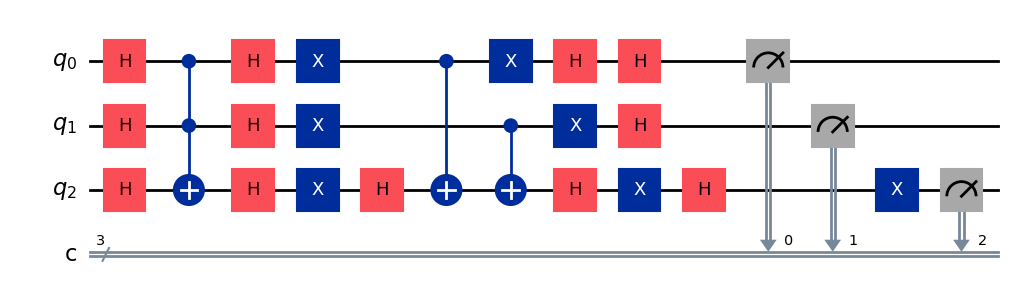

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 56] Best Fitness: 1.0302


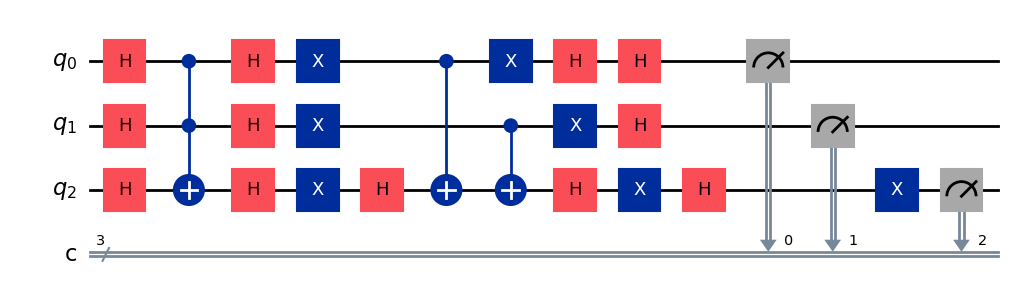

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 57] Best Fitness: 1.0302


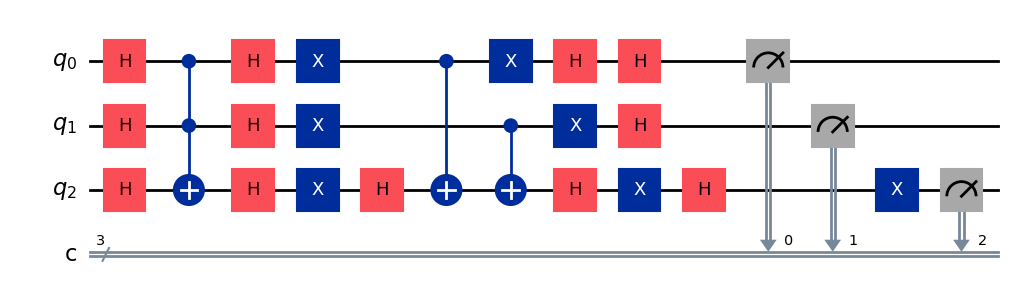

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 58] Best Fitness: 1.0302


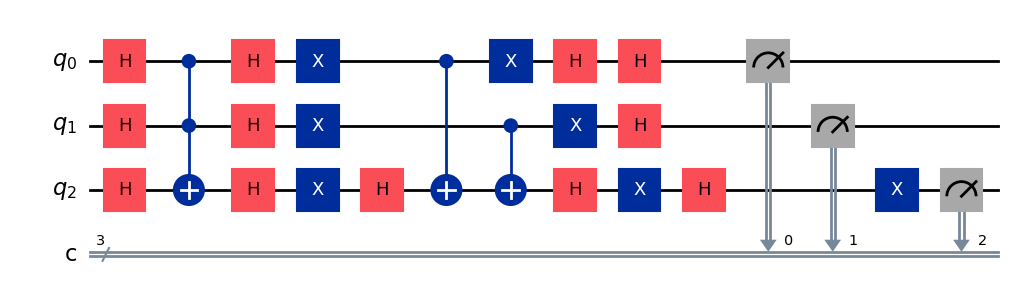

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 59] Best Fitness: 1.0302


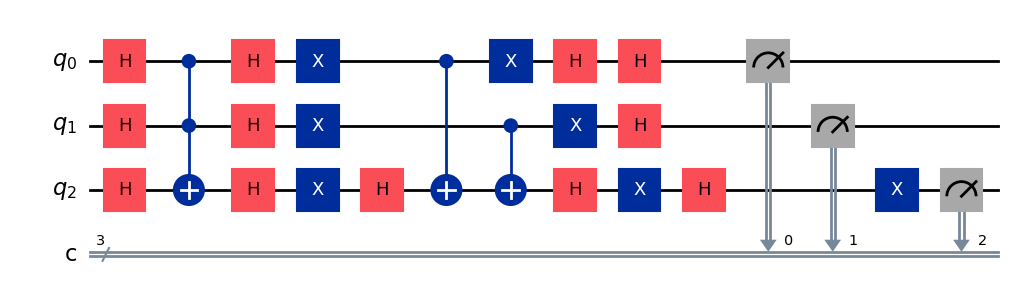

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 60] Best Fitness: 1.0302


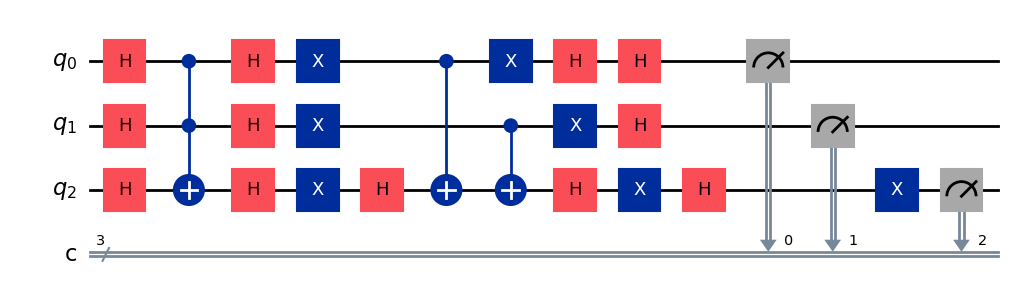

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 61] Best Fitness: 1.0302


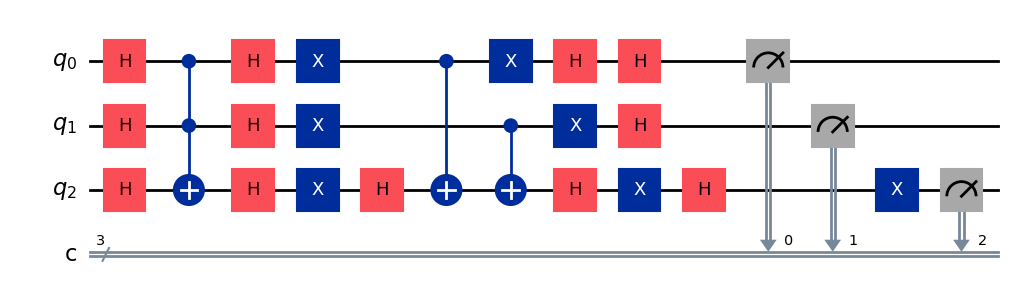

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 62] Best Fitness: 1.0302


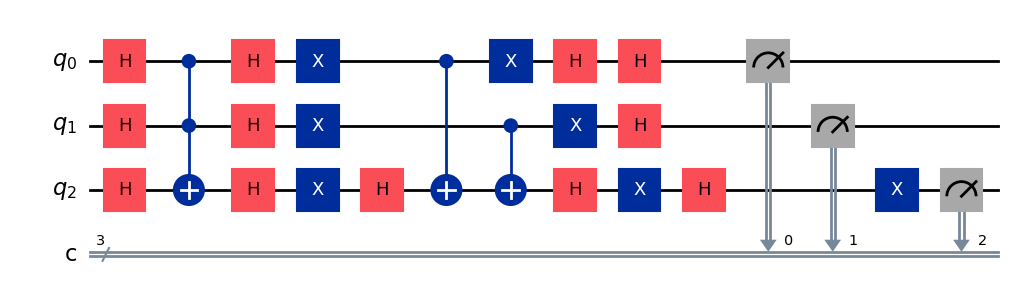

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 63] Best Fitness: 1.0302


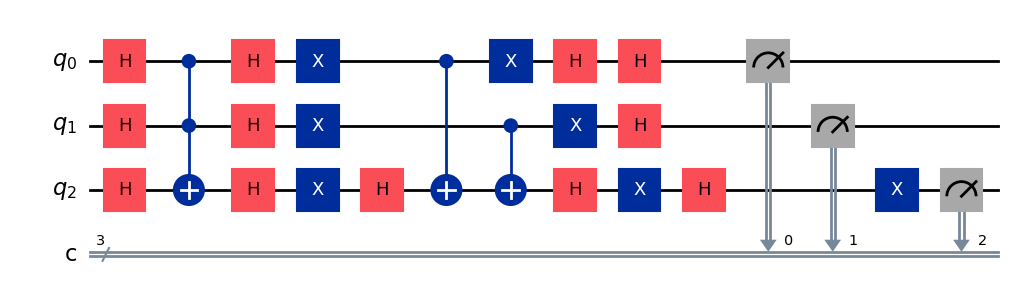

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 64] Best Fitness: 1.0302


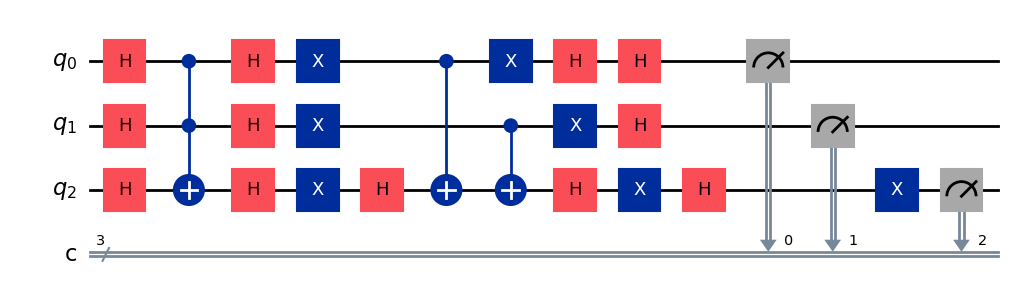

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 65] Best Fitness: 1.0302


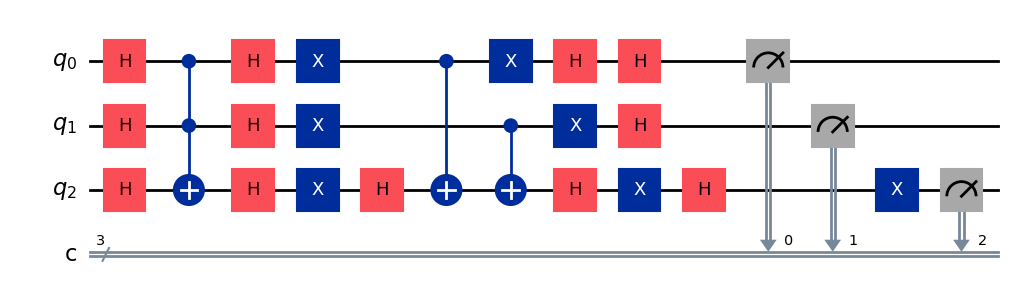

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 66] Best Fitness: 1.0302


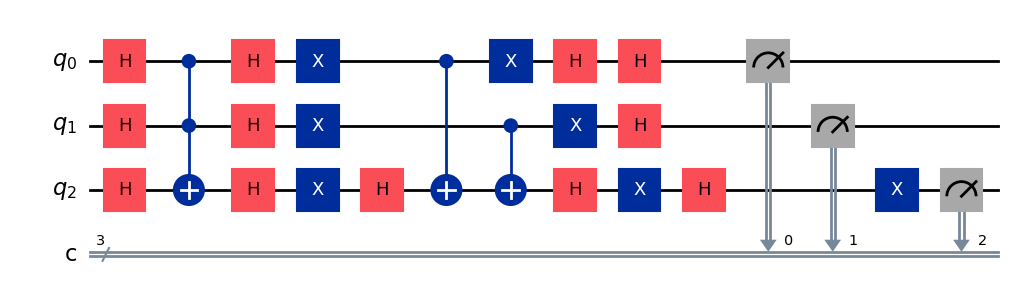

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 67] Best Fitness: 1.0302


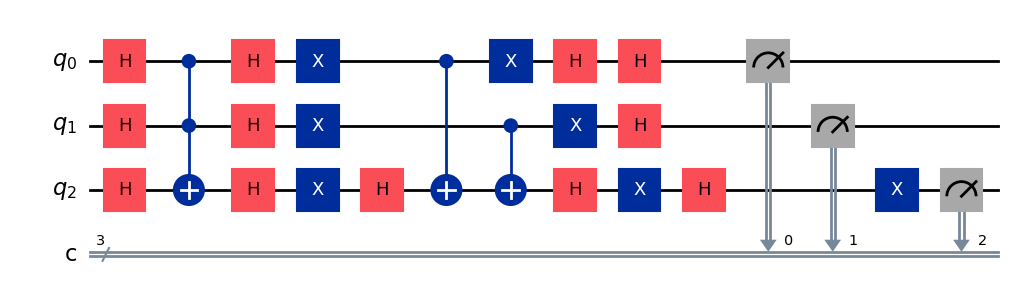

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 68] Best Fitness: 1.0302


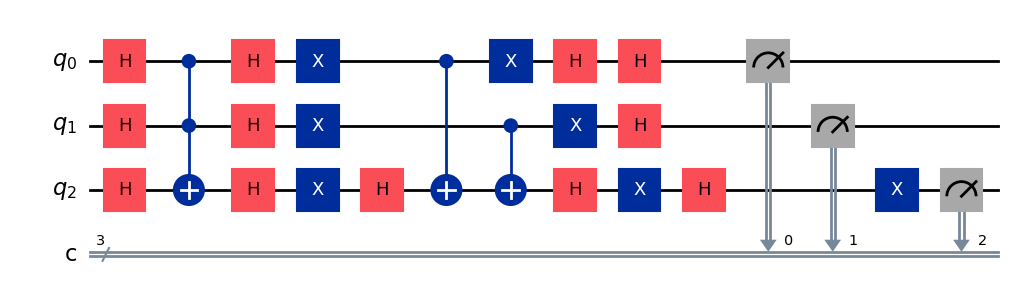

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 69] Best Fitness: 1.0302


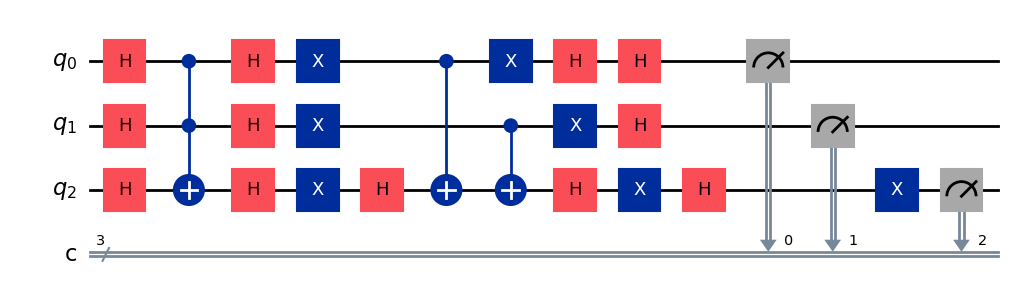

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 70] Best Fitness: 1.0302


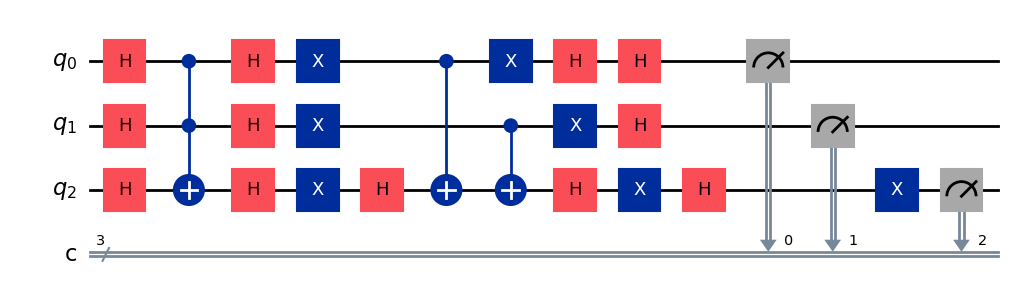

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 71] Best Fitness: 1.0302


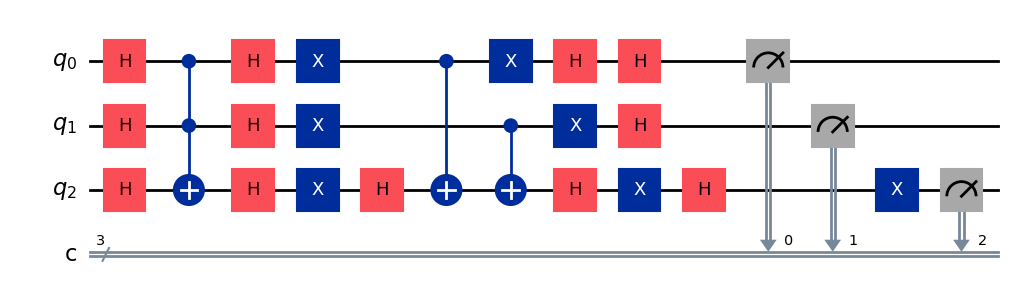

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 72] Best Fitness: 1.0302


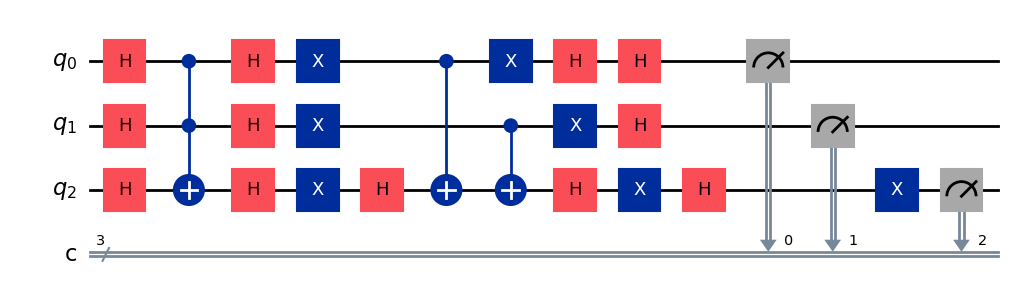

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 73] Best Fitness: 1.0302


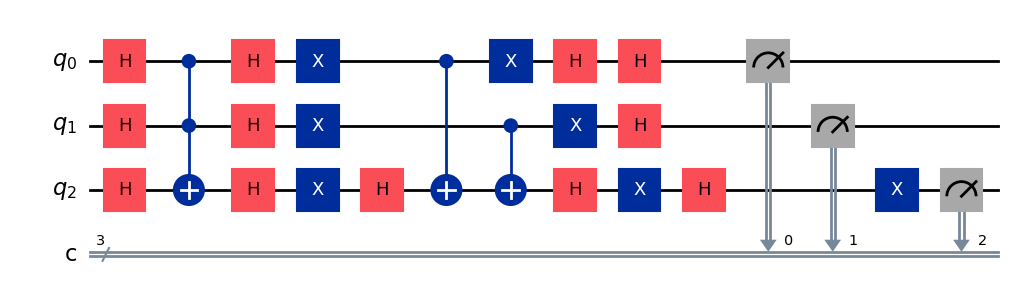

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 74] Best Fitness: 1.0302


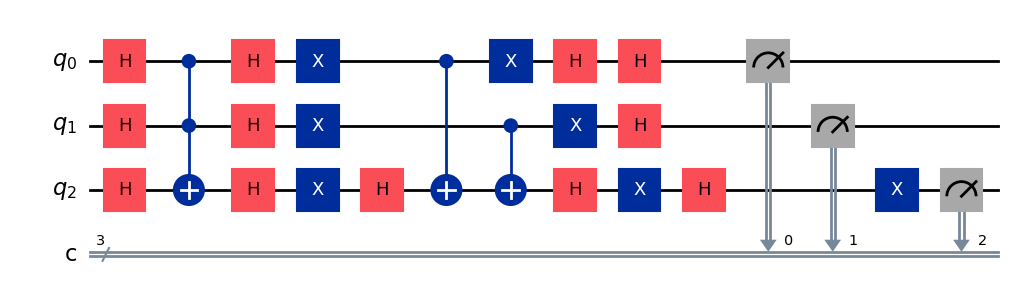

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 75] Best Fitness: 1.0302


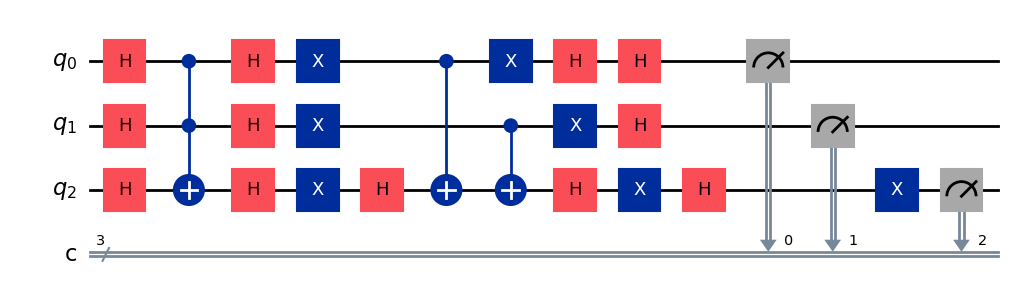

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 76] Best Fitness: 1.0302


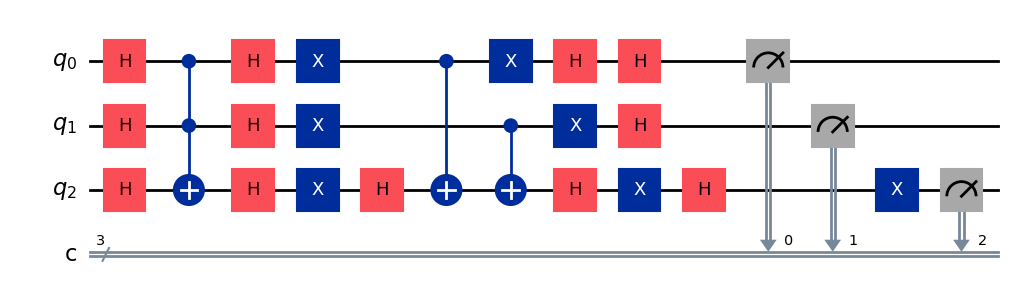

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 77] Best Fitness: 1.0302


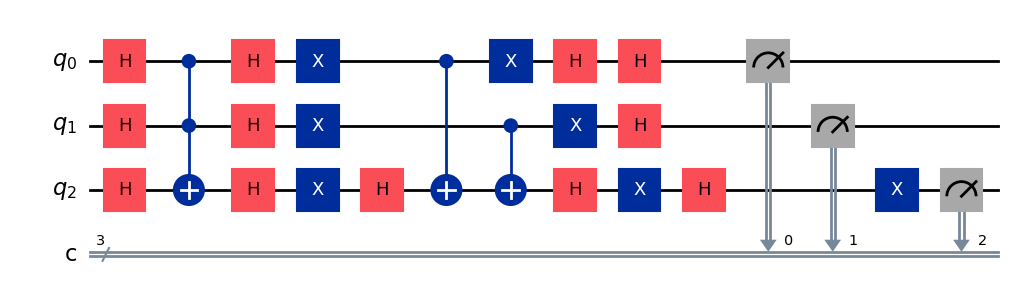

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 78] Best Fitness: 1.0302


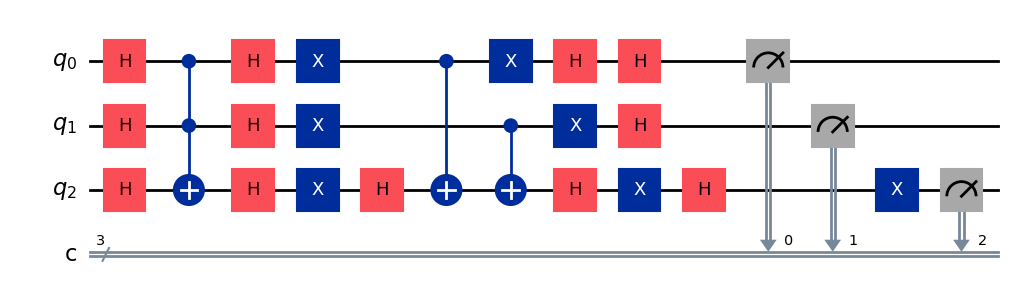

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 79] Best Fitness: 1.0302


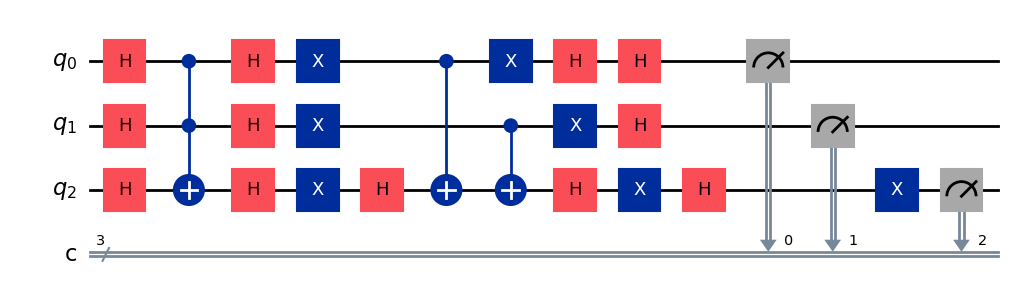

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 80] Best Fitness: 1.0302


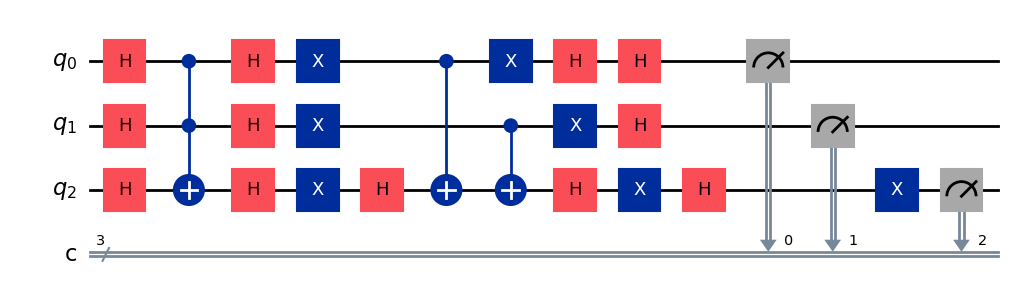

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 81] Best Fitness: 1.0302


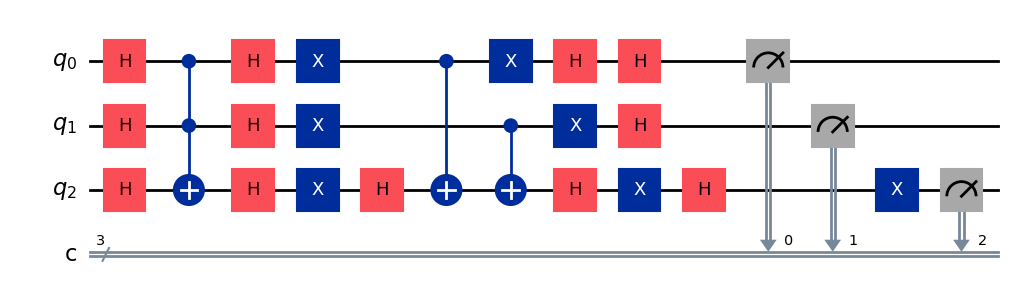

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 82] Best Fitness: 1.0302


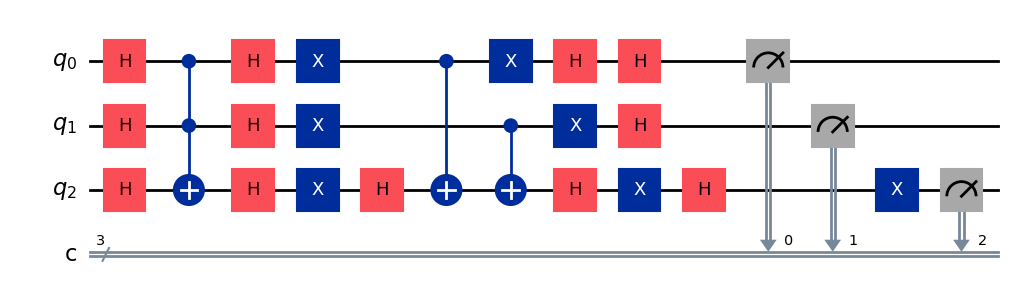

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 83] Best Fitness: 1.0302


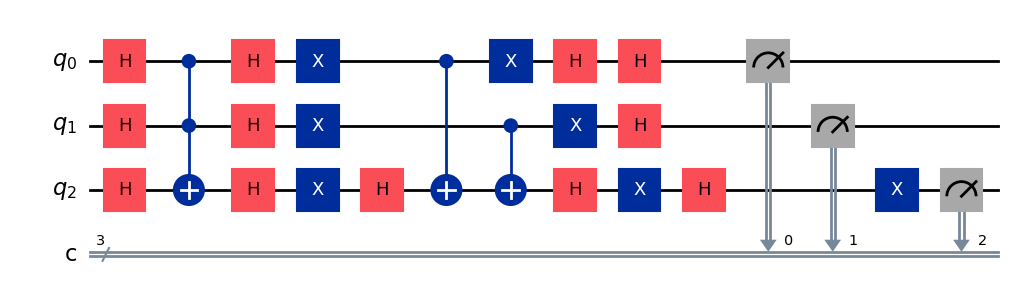

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 84] Best Fitness: 1.0302


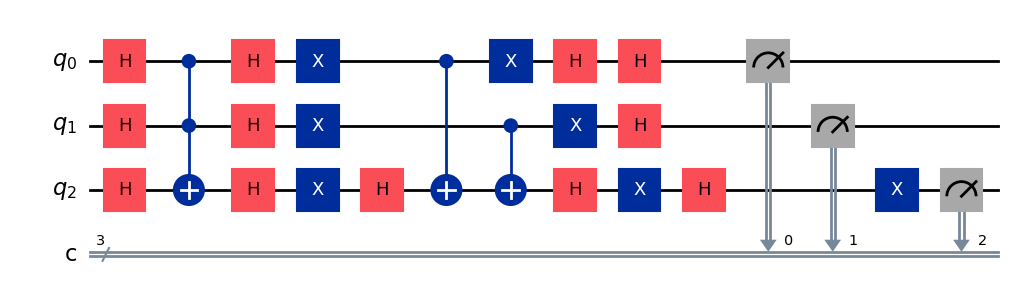

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 85] Best Fitness: 1.0302


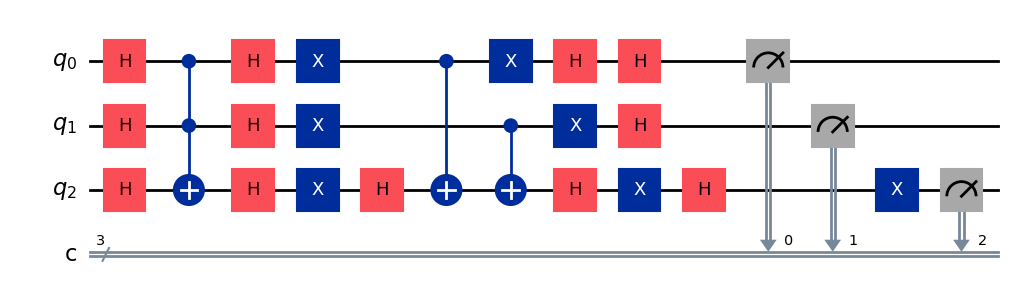

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 86] Best Fitness: 1.0302


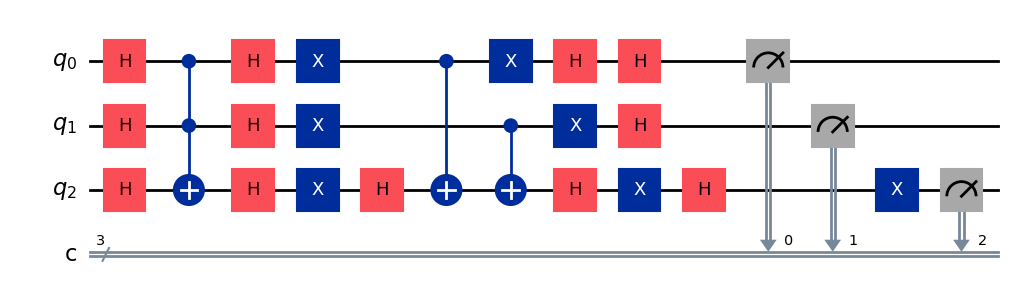

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 87] Best Fitness: 1.0302


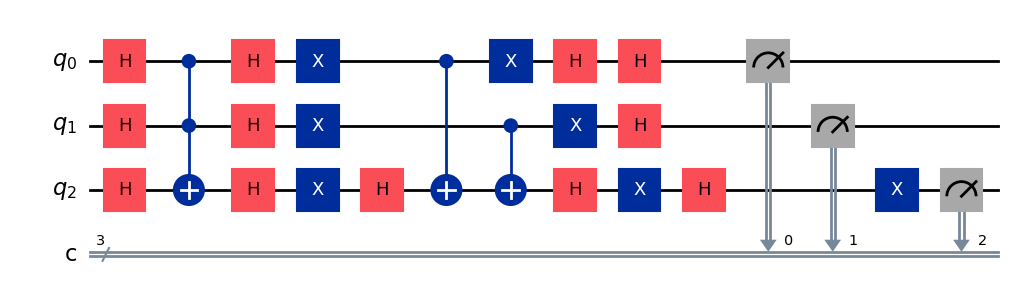

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 88] Best Fitness: 1.0302


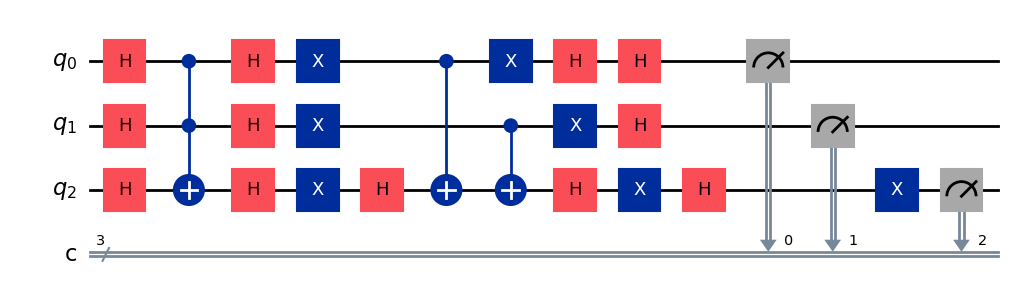

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 89] Best Fitness: 1.0302


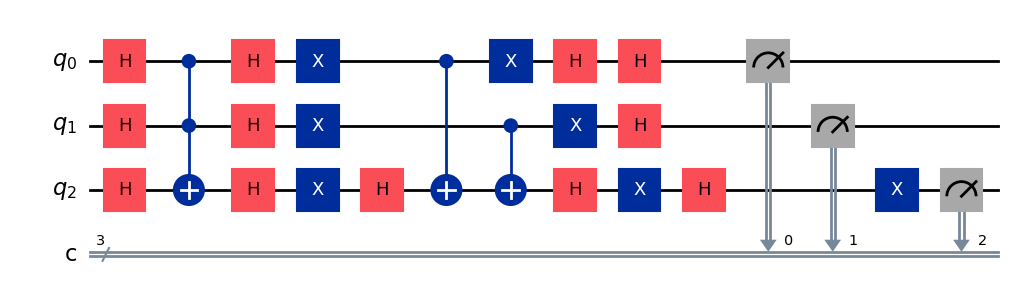

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 90] Best Fitness: 1.0302


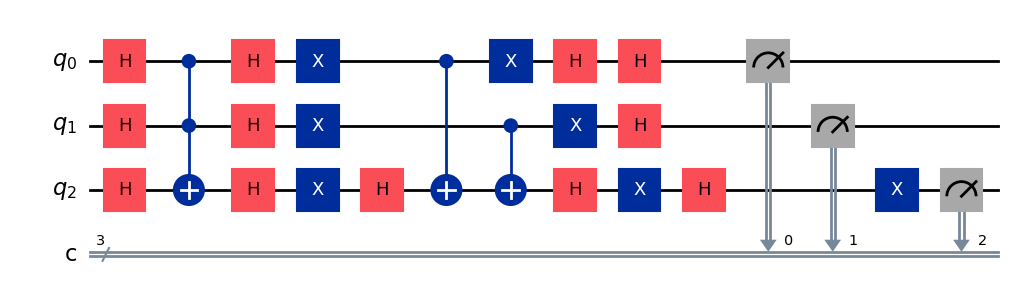

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 91] Best Fitness: 1.0302


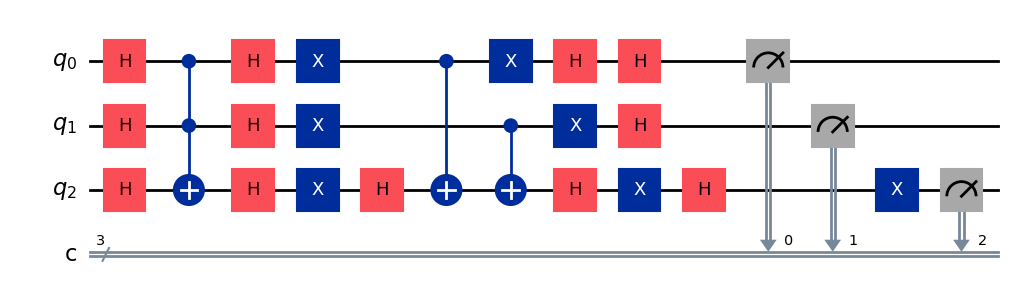

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 92] Best Fitness: 1.0302


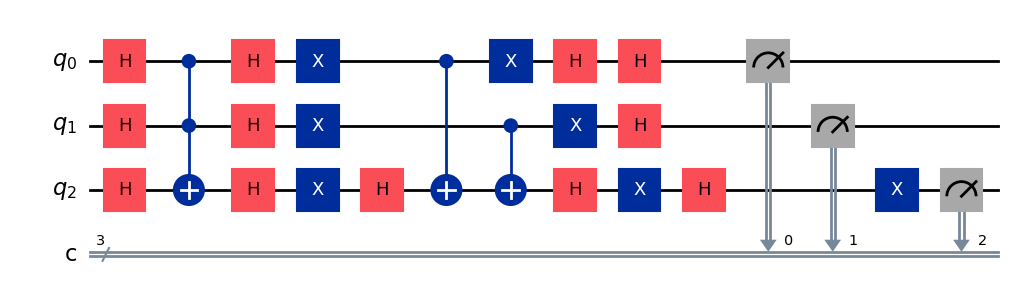

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 93] Best Fitness: 1.0302


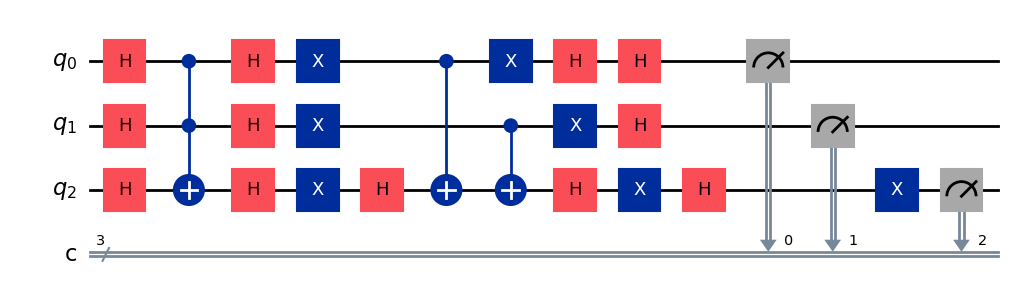

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 94] Best Fitness: 1.0302


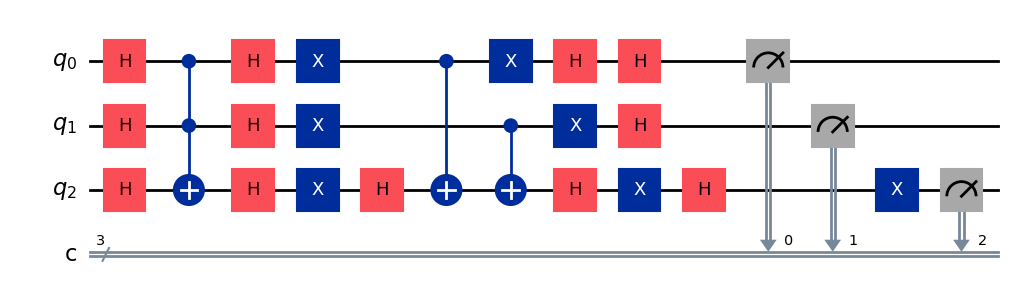

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 95] Best Fitness: 1.0302


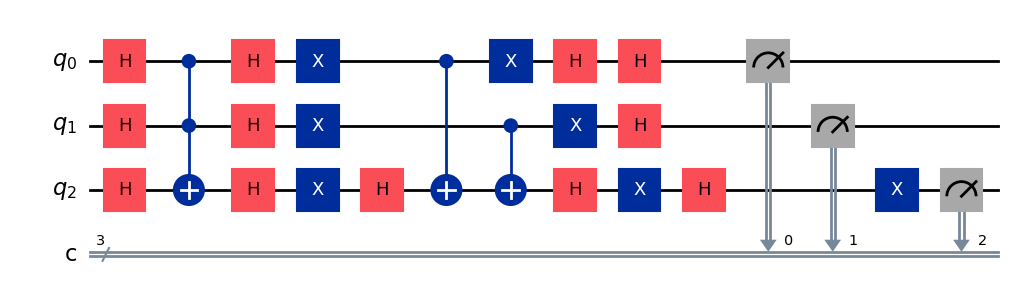

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 96] Best Fitness: 1.0302


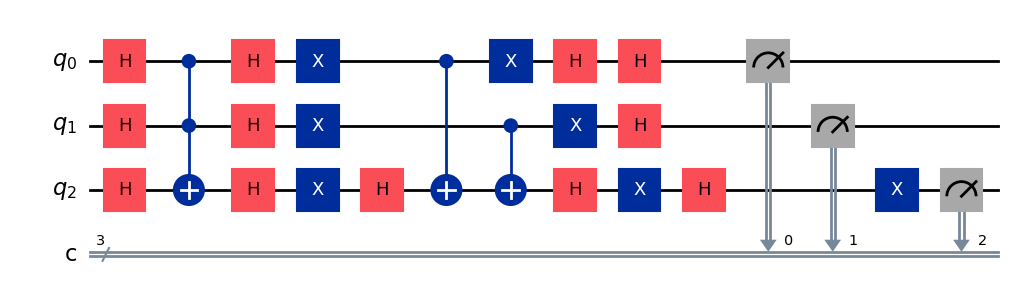

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 97] Best Fitness: 1.0302


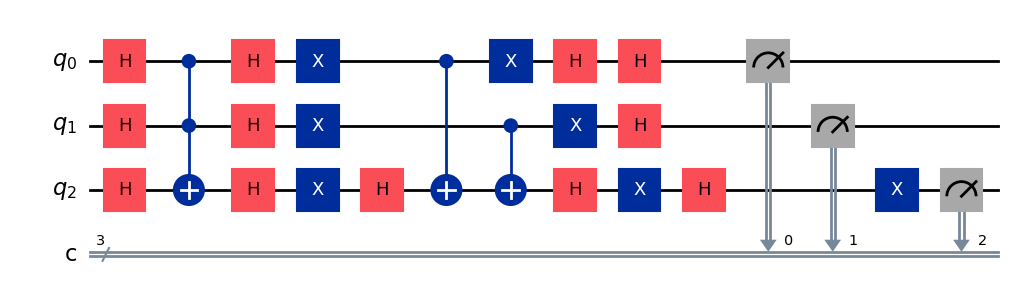

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 98] Best Fitness: 1.0302


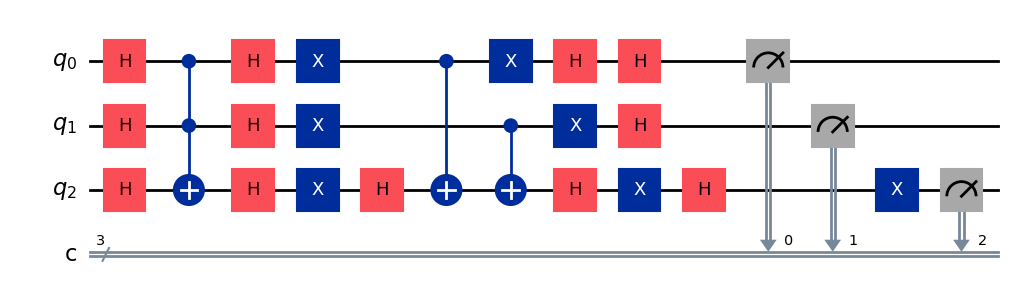

gen = 0 , Best fitness = (np.float64(1.03015625),)
gen = 1 , Best fitness = (np.float64(1.03015625),) , Number of invalids = 0

[Generation 99] Best Fitness: 1.0302


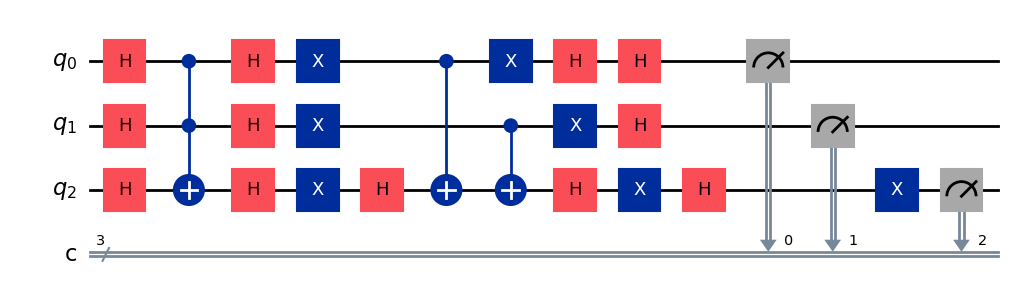

In [14]:
evaluator = CircuitEvaluator(shots=512, log_dir=LOG_DIR)

population = toolbox.populationCreator(
    pop_size=POPULATION_SIZE,
    bnf_grammar=BNF_GRAMMAR,
    min_init_depth=MIN_INIT_DEPTH,
    max_init_depth=MAX_INIT_DEPTH,
    codon_size=CODON_SIZE,
    codon_consumption=CODON_CONSUMPTION,
    genome_representation=GENOME_REPRESENTATION
)
hof = tools.HallOfFame(HALLOFFAME_SIZE)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

generations_list = []
best_fitness_list = []
avg_gate_count_list = []

for gen in range(MAX_GENERATIONS):
    population, logbook = algorithms.ge_eaSimpleWithElitism(
        population,
        toolbox,
        cxpb=P_CROSSOVER,
        mutpb=P_MUTATION,
        ngen=N_GEN,
        elite_size=ELITE_SIZE,
        bnf_grammar=BNF_GRAMMAR,
        codon_size=CODON_SIZE,
        max_tree_depth=MAX_TREE_DEPTH,
        codon_consumption=CODON_CONSUMPTION,
        report_items=REPORT_ITEMS,
        genome_representation=GENOME_REPRESENTATION,
        stats=stats,
        halloffame=hof,
        verbose=False
    )

    best_ind = tools.selBest(population, 1)[0]
    best_ind.generation = gen

    best_phenotype = evaluator.decode_individual(best_ind)
    if best_phenotype is not None:
        fitness_val, logs = fitness_function_specialized_first_bit(best_phenotype, 
                                                                   shots=512, 
                                                                   threshold=0.48, 
                                                                   target_first_bit="0", 
                                                                   log_states=True)
        best_fitness_list.append(fitness_val)
        if logs:
            avg_gate = np.mean([log["gate_count"] for log in logs])
        else:
            avg_gate = 0
        avg_gate_count_list.append(avg_gate)
        generations_list.append(gen)

    qc = evaluator.execute_circuit(best_phenotype)
    if qc:
        print(f"\n[Generation {gen}] Best Fitness: {best_ind.fitness.values[0]:.4f}")
        display(qc.draw("mpl"))
pool.close()
pool.join()


[HALL OF FAME]
Individual 1:
Genome: [271, 144, 366, 106, 74, 338, 312, 341, 175, 188, 324, 176, 8, 76, 12, 144, 8, 76, 12, 15, 169, 374, 304, 27, 14, 144, 366, 106, 74, 91, 348, 137, 44, 304, 27, 14, 304, 27, 14, 353, 31, 197, 374, 188, 324, 176, 8, 222, 299, 175, 341, 374, 188, 324, 176, 8, 106, 74, 299, 175, 341, 374, 188, 324, 176, 8, 298, 304, 27, 132, 130, 2, 31, 231, 235, 44, 399, 199]
Phenotype: "qc = QuantumCircuit(3, 3)\n" "qc.h(0)\n" "qc.h(1)\n" "qc.h(2)\n" "## Begin Oracle\n" "qc.ccx(" "1,0,2" ")\n" "## End Oracle\n" "## Begin Diffuser\n" "qc.h(0)\n" "qc.h(1)\n" "qc.h(2)\n" "qc.x(0)\n" "qc.x(1)\n" "qc.x(2)\n" "qc.h(2)\n" "qc.cx(0,2)\n" "qc.cx(1,2)\n" "qc.h(2)\n" "qc.x(0)\n" "qc.x(1)\n" "qc.x(2)\n" "qc.h(0)\n" "qc.h(1)\n" "qc.h(2)\n" "qc.x(" "2" ")\n" "qc.h(" "0" ")\n" "## End Diffuser\n" "qc.measure(0, 0)\n" "qc.measure(1, 1)\n" "qc.measure(2, 2)\n"
Fitness: 1.03015625
Marked State: 000
Oracle:
qc.x(0)
qc.x(1)
qc.x(2)
qc.h(2)
qc.mcx(list(range(2)), 2)
qc.h(2)
qc.x(0)
qc.x(

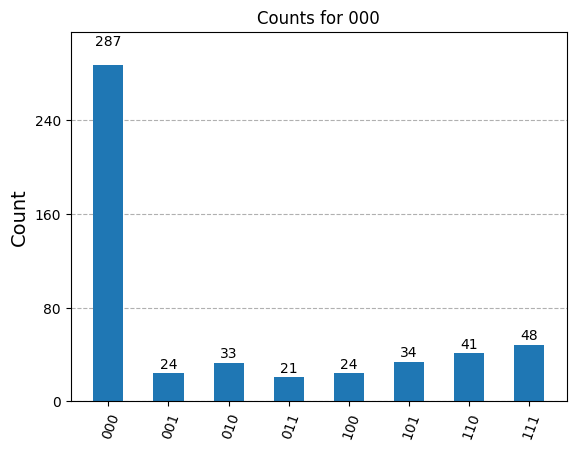

Marked State: 001
Oracle:
qc.x(0)
qc.x(1)
qc.h(2)
qc.mcx(list(range(2)), 2)
qc.h(2)
qc.x(0)
qc.x(1)

p(marked): 0.5605, error: 0.4395
Gate Count: 31


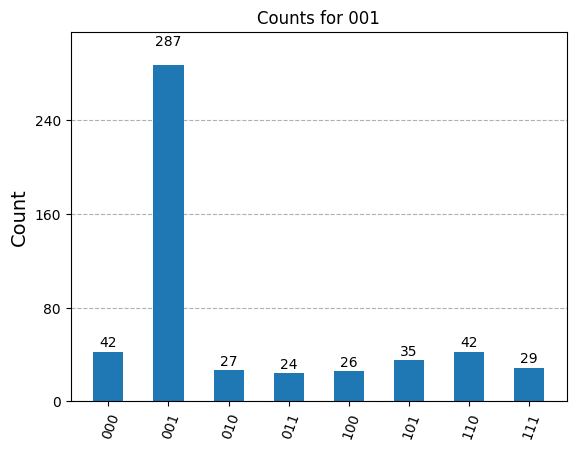

Marked State: 010
Oracle:
qc.x(0)
qc.x(2)
qc.h(2)
qc.mcx(list(range(2)), 2)
qc.h(2)
qc.x(0)
qc.x(2)

p(marked): 0.5566, error: 0.4434
Gate Count: 31


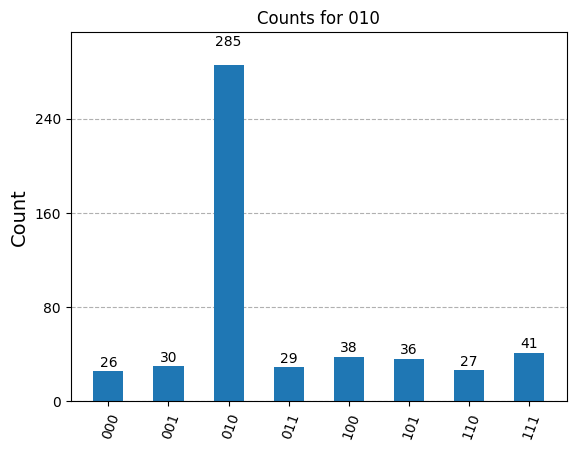

Marked State: 011
Oracle:
qc.x(0)
qc.h(2)
qc.mcx(list(range(2)), 2)
qc.h(2)
qc.x(0)

p(marked): 0.5664, error: 0.4336
Gate Count: 29


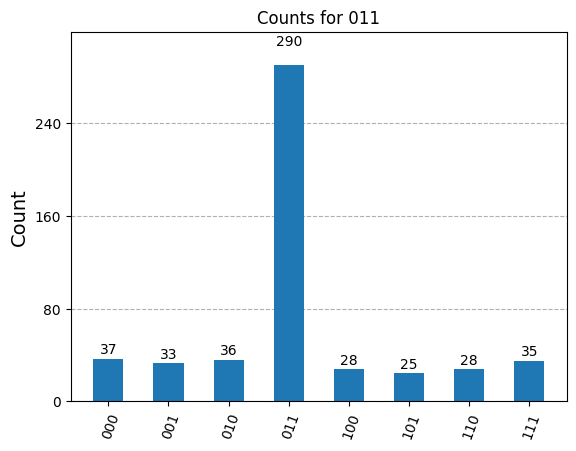

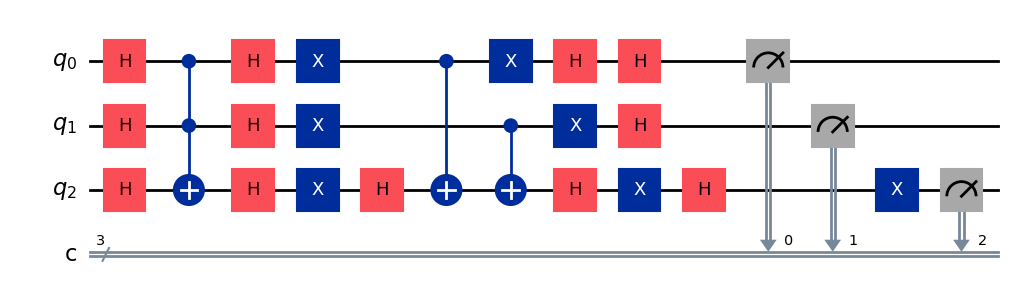


Best Individual's Fitness: 1.03015625


In [15]:
print("\n[HALL OF FAME]")
for i, hof_ind in enumerate(hof.items):
    print(f"Individual {i+1}:")
    print(f"Genome: {hof_ind.genome}")
    print(f"Phenotype: {hof_ind.phenotype}")
    print(f"Fitness: {hof_ind.fitness.values[0]}")

best_ind = hof.items[0]
best_phenotype = evaluator.decode_individual(best_ind)
fitness, log_per_state = fitness_function_specialized_first_bit(best_phenotype, log_states=True)

for log in log_per_state:
    print(f"Marked State: {log['state']}")
    print(f"Oracle:\n{log['oracle']}")
    print(f"p(marked): {log['p_marked']:.4f}, error: {log['error']:.4f}")
    print(f"Gate Count: {log['gate_count']}")
    display(plot_histogram(log["counts"], title=f"Counts for {log['state']}"))

best_circuit = evaluator.execute_circuit(best_phenotype)
if best_circuit:
    display(best_circuit.draw("mpl"))
else:
    print("The best individual could not be decoded into a valid circuit.")

print("\nBest Individual's Fitness:", best_ind.fitness.values[0])

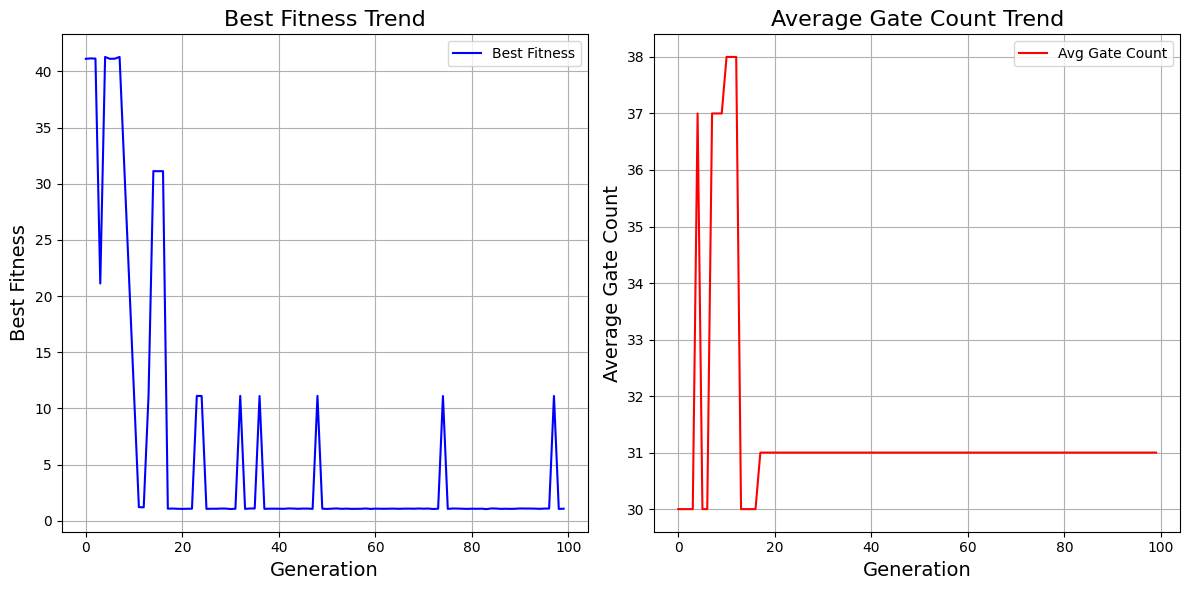

In [16]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

ax1.plot(generations_list, best_fitness_list, 'b-', label="Best Fitness")
ax1.set_xlabel("Generation", fontsize=14)
ax1.set_ylabel("Best Fitness", fontsize=14)
ax1.set_title("Best Fitness Trend", fontsize=16)
ax1.grid(True)
ax1.legend()

ax2.plot(generations_list, avg_gate_count_list, 'r-', label="Avg Gate Count")
ax2.set_xlabel("Generation", fontsize=14)
ax2.set_ylabel("Average Gate Count", fontsize=14)
ax2.set_title("Average Gate Count Trend", fontsize=16)
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

# TODO: Send circuit Job to IBM

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

# Named registers for compatibility with SamplerV2 result
qr = QuantumRegister(3, name="q")
cr = ClassicalRegister(3, name="cr")
qc2 = QuantumCircuit(qr, cr)

# Superposition
qc2.h(qr[0])
qc2.h(qr[1])
qc2.h(qr[2])

# Oracle
qc2.ccx(qr[1], qr[0], qr[2])

# Diffuser
qc2.h(qr[0])
qc2.h(qr[1])
qc2.h(qr[2])
qc2.x(qr[0])
qc2.x(qr[1])
qc2.x(qr[2])
qc2.h(qr[2])
qc2.cx(qr[0], qr[2])
qc2.cx(qr[1], qr[2])
qc2.h(qr[2])
qc2.x(qr[0])
qc2.x(qr[1])
qc2.x(qr[2])
qc2.h(qr[0])
qc2.h(qr[1])
qc2.h(qr[2])
qc2.x(qr[2])
qc2.h(qr[0])

# Measurement
qc2.measure(qr[0], cr[0])
qc2.measure(qr[1], cr[1])
qc2.measure(qr[2], cr[2])

In [2]:
# %%
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram

# Initialize Runtime Service
service = QiskitRuntimeService(channel="ibm_quantum")

# Select the least busy real backend
backend = service.least_busy(operational=True, simulator=False)
print(f"Selected backend: {backend.name}")

# Create the V1 Sampler *after* choosing the backend
sampler = Sampler(mode=backend)
sampler.options.default_shots = 512

Selected backend: ibm_brisbane


In [3]:
pm = generate_preset_pass_manager(target=backend.target, optimization_level=3)
# Transpile for current backend
circuit2_isa = pm.run(qc2)

# Execute
result2 = sampler.run([circuit2_isa]).result()

# Get measurement counts
counts2 = result2[0].data.cr.get_counts()

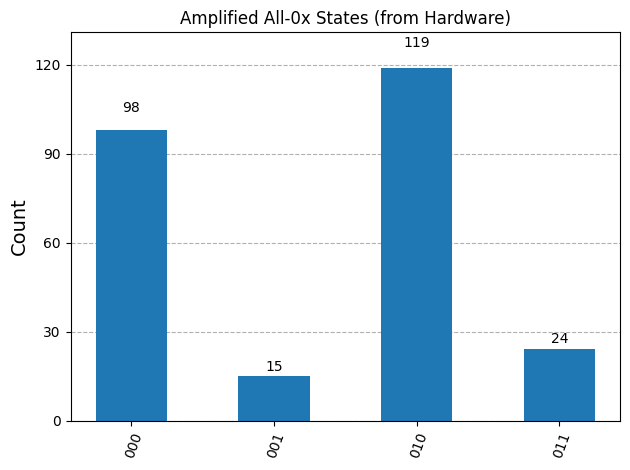

In [4]:
# Filter: only states that start with '0'
targeted_counts = {k: v for k, v in counts2.items() if k.startswith("0")}

# Optionally: sort by value for cleaner plotting
targeted_counts = dict(sorted(targeted_counts.items(), key=lambda item: item[1], reverse=True))

# Plot
plot_histogram(targeted_counts, title="Amplified All-0x States (from Hardware)")

In [10]:
import matplotlib.pyplot as plt

def plot_single_state(counts: dict, target: str = "001"):
    """Plot a single bar for the target state showing how well it was amplified."""
    count = counts.get(target, 0)
    
    plt.figure(figsize=(4, 5))
    bar = plt.bar([target], [count], color='tab:blue')
    plt.text(0, count + 5, str(count), ha='center', va='bottom', fontsize=12)
    plt.title(f"Counts for {target}")
    plt.ylabel("Count")
    plt.ylim(0, max(512, count + 50))  # adjust top for visibility
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

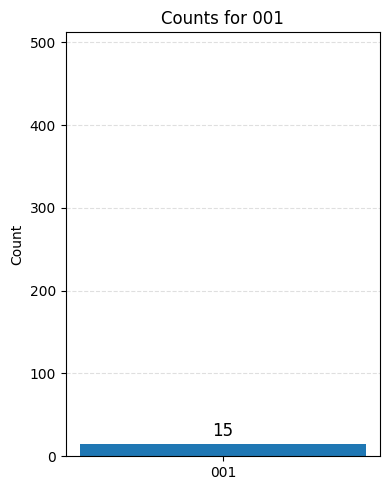

In [11]:
plot_single_state(counts2, target="001")